## Import Python Package

In [ ]:
!pip install rdkit
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, rdMolDescriptors, rdFingerprintGenerator

## Set Up Global Variables

In [ ]:
RANDOM_SEED = 42

## Import 'processed_DrugSolubilityData.csv' and 'compound' data files as Pandas Dataframes

In [ ]:
# Import 'processed_DrugSolubilityData.csv' file
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vR6vel81WrzQdxMc7Gp1bH0zZVIYvne2VUUnwOOJn-gHPx-l0cm4cry4J3iWu0qUA/pub?gid=2051224698&single=true&output=csv"
df = pd.read_csv(url)

# Import the "compound.csv" file
url_compound = "https://docs.google.com/spreadsheets/d/e/2PACX-1vShVW7aUkUq3MLQ-dYWJWjePYSXf3CtVdPBC4ddiw-3HPbnY1s6BQ8O9ualjgJKEg/pub?gid=1310793638&single=true&output=csv"
df_compound = pd.read_csv(url_compound)

## Break the cmp_ids_solvent and cmp_mole_fractions_solvent into separate columns

In [ ]:
# Convert string columns into list columns
# Convert the column to string before applying ast.literal_eval
df['cmp_ids_solvent'] = df['cmp_ids_solvent'].astype(str).apply(ast.literal_eval)
df['cmp_mole_fractions_solvent'] = df['cmp_mole_fractions_solvent'].astype(str).apply(ast.literal_eval)

# Split into separate columns while keeping correlation
# Define data extraction function
def extract_solvent_info(row, index):
    try:
        return row['cmp_ids_solvent'][index], row['cmp_mole_fractions_solvent'][index]
    except IndexError:
        return None, None  # For mixtures that have fewer solvents

# Apply to create new columns
df[['Solvent1_id', 'Solvent1_frac']] = df.apply(lambda row: pd.Series(extract_solvent_info(row, 0)), axis=1)
df[['Solvent2_id', 'Solvent2_frac']] = df.apply(lambda row: pd.Series(extract_solvent_info(row, 1)), axis=1)

# Map solvent IDs to names
id_to_name = dict(zip(df_compound['compound_id'], df_compound['name']))

df['Solvent1_name'] = df['Solvent1_id'].map(id_to_name)
df['Solvent2_name'] = df['Solvent2_id'].map(id_to_name)

# Create df_49 AFTER all solvent columns are added to df
df_49 = df[df['cmp_ids_drug'].astype(str).str.strip() == '[49]'].copy()

## 0.1.1 SMILES and RDKit Mol Objects for Solute and Solvents

In [ ]:
df_compound['compound_id'] = pd.to_numeric(df_compound['compound_id'], errors='coerce')

# Get the SMILES for the drug (Flutamide, cmp_id=49)
drug_smiles_49 = df_compound[df_compound['compound_id'] == 49]['smiles'].iloc[0]
df_49['drug_mol'] = df_49['cmp_ids_drug'].apply(lambda x: Chem.MolFromSmiles(drug_smiles_49))

# Map solvent IDs to SMILES
id_to_smiles = dict(zip(df_compound['compound_id'], df_compound['smiles']))

df_49['Solvent1_smiles'] = df_49['Solvent1_id'].map(id_to_smiles)
df_49['Solvent2_smiles'] = df_49['Solvent2_id'].map(id_to_smiles)

# Create Mol objects for solvents, handling NaN for single solvent systems
df_49['Solvent1_mol'] = df_49['Solvent1_smiles'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None)
df_49['Solvent2_mol'] = df_49['Solvent2_smiles'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None)

## 0.1.2 Hydrogen Bonding (HBA & HBD), Polarity (logP & TPSA) Features for Solute and Solvent

In [ ]:
def get_molecular_properties(df):
  # Helper function to ensure descriptor columns exist for a given prefix
  def _check_descriptor_columns(df_target, prefix):
    descriptors = ['HBA', 'HBD', 'logP', 'TPSA']
    for desc in descriptors:
      col_name = f'{prefix}_{desc}'
      if col_name not in df_target.columns:
        df_target[col_name] = None

  # Ensure descriptor columns exist for drug, Solvent1, and Solvent2
  _check_descriptor_columns(df, 'drug')
  _check_descriptor_columns(df, 'Solvent1')
  _check_descriptor_columns(df, 'Solvent2')

  for index, row in df.iterrows():
    drug_mol = row['drug_mol']
    Solvent1_mol = row['Solvent1_mol']
    Solvent2_mol = row['Solvent2_mol']

    if drug_mol is not None:
      df.at[index, 'drug_HBA'] = Descriptors.NumHAcceptors(drug_mol)
      df.at[index, 'drug_HBD'] = Descriptors.NumHDonors(drug_mol)
      df.at[index, 'drug_logP'] = Descriptors.MolLogP(drug_mol)
      df.at[index, 'drug_TPSA'] = rdMolDescriptors.CalcTPSA(drug_mol)


    if Solvent1_mol is not None:
      df.at[index, 'Solvent1_HBA'] = Descriptors.NumHAcceptors(Solvent1_mol)
      df.at[index, 'Solvent1_HBD'] = Descriptors.NumHDonors(Solvent1_mol)
      df.at[index, 'Solvent1_logP'] = Descriptors.MolLogP(Solvent1_mol)
      df.at[index, 'Solvent1_TPSA'] = rdMolDescriptors.CalcTPSA(Solvent1_mol)

    if Solvent2_mol is not None:
      df.at[index, 'Solvent2_HBA'] = Descriptors.NumHAcceptors(Solvent2_mol)
      df.at[index, 'Solvent2_HBD'] = Descriptors.NumHDonors(Solvent2_mol)
      df.at[index, 'Solvent2_logP'] = Descriptors.MolLogP(Solvent2_mol)
      df.at[index, 'Solvent2_TPSA'] = rdMolDescriptors.CalcTPSA(Solvent2_mol)

  return df
df_49 = get_molecular_properties(df_49)

## 0.1.3 Dielectric Constant and Hansen Parametes for Solvents

In [ ]:
# -------------------------------------------------
# 1. Reference / experimental data
# -------------------------------------------------
water_coeffs = {"A": 87.740, "B": -0.400081, "C": 9.398e-4, "D": -1.410e-6}

# Updated solvent names and standardized 'THF' to 'Tetrahydrofuran'
eps_ref = {
    "Ethanol": 24.5,
    "2-Propanol": 19.92,
    "1,4-Dioxane": 2.25,
    "Acetonitrile": 37.5,
    "Acetone": 20.7,
    "Ethyl Acetate": 6.02,
    "Tetrahydrofuran": 7.58, # Changed from "THF"
    "Water": None  # handled separately
}

alphas = {
    "Ethanol": 0.018,
    "2-Propanol": 0.018,
    "1,4-Dioxane": 0.012,
    "Acetonitrile": 0.017,
    "Acetone": 0.020,
    "Ethyl Acetate": 0.015,
    "Tetrahydrofuran": 0.014 # Changed from "THF"
}

hansen_298 = {
    "Water": {"dD":15.5, "dP":16.0, "dH":42.3},
    "Ethanol": {"dD":15.8, "dP":8.8, "dH":19.4},
    "2-Propanol": {"dD":16.0, "dP":6.1, "dH":16.4},
    "1,4-Dioxane": {"dD":19.0, "dP":1.8, "dH":7.4},
    "Acetonitrile": {"dD":15.3, "dP":18.0, "dH":6.1},
    "Acetone": {"dD":15.5, "dP":10.4, "dH":7.0},
    "Ethyl Acetate": {"dD":15.8, "dP":5.3, "dH":7.2},
    "Tetrahydrofuran": {"dD":16.8, "dP":5.7, "dH":8.0} # Changed from "THF"
}

# -------------------------------------------------
# 2. Dielectric functions
# -------------------------------------------------
def epsilon_water(T_kelvin):
    T_C = T_kelvin - 273.15
    A, B, C, D = water_coeffs["A"], water_coeffs["B"], water_coeffs["C"], water_coeffs["D"]
    return A + B*T_C + C*T_C**2 + D*T_C**3

def epsilon_solvent(solvent, T_kelvin):
    # Ensure proper capitalization and handle potential NaN from solvent.title() for non-string types
    if pd.isna(solvent):
        return np.nan
    solvent_cap = solvent.title().replace("Tetrahydrofuran", "Tetrahydrofuran") # already standardized above
    if solvent_cap == "Water":
        return epsilon_water(T_kelvin)
    if solvent_cap not in eps_ref:
        # If a solvent name is not found, return NaN for its dielectric constant
        return np.nan
    eps0 = eps_ref[solvent_cap]
    alpha = alphas[solvent_cap]
    T_C = T_kelvin - 273.15
    return eps0 * np.exp(-alpha * (T_C - 25))

# -------------------------------------------------
# 3. Hansen parameters
# -------------------------------------------------
def hansen_T(solvent, T_kelvin, beta=0.008, gamma=8e-4):
    if pd.isna(solvent):
        return np.nan, np.nan, np.nan
    solvent_cap = solvent.title().replace("Tetrahydrofuran", "Tetrahydrofuran") # already standardized above
    if solvent_cap not in hansen_298:
        # If a solvent name is not found, return NaN for its Hansen parameters
        return np.nan, np.nan, np.nan
    h298 = hansen_298[solvent_cap]
    T0 = 298.15
    scale = 1 / (1 + gamma*(T_kelvin - T0))
    dD_T = h298["dD"] * scale
    dP_T = h298["dP"] * scale
    dH_T = h298["dH"] * np.exp(-beta*(T_kelvin - T0))
    return dD_T, dP_T, dH_T

# -------------------------------------------------
# 4. Apply to DataFrame (modified to accept a prefix for new columns)
# -------------------------------------------------
def add_solvent_properties(df, temp_col='Temperature, K', solvent_col='Solvent', prefix=''):
    dielectrics = []
    dD_list, dP_list, dH_list = [], [], []

    # Capitalize solvent names consistently, handling NaN values
    df[solvent_col] = df[solvent_col].apply(
        lambda x: "Tetrahydrofuran" if pd.notna(x) and str(x).lower() == "tetrahydrofuran" else (str(x).title() if pd.notna(x) else np.nan)
    )

    for _, row in df.iterrows():
        T = row[temp_col]
        solvent = row[solvent_col]

        # Only calculate if solvent is not NaN
        if pd.notna(solvent):
            dielectrics.append(epsilon_solvent(solvent, T))
            dD, dP, dH = hansen_T(solvent, T)
            dD_list.append(dD)
            dP_list.append(dP)
            dH_list.append(dH)
        else:
            dielectrics.append(np.nan)
            dD_list.append(np.nan)
            dP_list.append(np.nan)
            dH_list.append(np.nan)

    df[f'{prefix}Dielectric'] = dielectrics
    df[f'{prefix}δD'] = dD_list
    df[f'{prefix}δP'] = dP_list
    df[f'{prefix}δH'] = dH_list
    return df

# Include solvent 1 and solvent 2 dielectric constant and Hansen parameters
df_49 = add_solvent_properties(df_49, temp_col='Temperature, K', solvent_col='Solvent1_name', prefix='Solvent1_')
df_49 = add_solvent_properties(df_49, temp_col='Temperature, K', solvent_col='Solvent2_name', prefix='Solvent2_')

#df_49.columns

## 0.1.4 Hansen Parameter for Solute - Flutamide

In [ ]:
# Flutamide estimated Hansen parameters (room temp, 298 K)
flutamide_hansen = {"dD": 17.0, "dP": 8.0, "dH": 7.0}  # approximate sum of contributions

def hansen_solute_T(solute_name, T_kelvin, beta=0.008, gamma=8e-4):
    """
    Returns Hansen parameters for the solute.
    Currently only handles flutamide; extendable to other solutes.
    """
    if solute_name.lower() != "flutamide":
        raise ValueError("Solute not supported. Only 'flutamide' is implemented.")

    T0 = 298.15
    scale = 1 / (1 + gamma*(T_kelvin - T0))
    h298 = flutamide_hansen # Since it's hardcoded for flutamide
    dD_T = h298["dD"] * scale
    dP_T = h298["dP"] * scale
    dH_T = h298["dH"] * np.exp(-beta*(T_kelvin - T0))
    return dD_T, dP_T, dH_T

# Apply the function row-wise, passing the string 'flutamide' as the solute_name and expanding the returned tuple into new columns
df_49[['drug_δD', 'drug_δP', 'drug_δH']] = df_49.apply(
    lambda row: hansen_solute_T("flutamide", row['Temperature, K']),
    axis=1,
    result_type='expand'
)

## 0.1.5 Hansen Distance (Ra) for Solvent1 and Solvent2

In [ ]:
# Function to calculate Hansen Distance (Ra)
def hansen_distance_Ra(dD1, dP1, dH1, dD2, dP2, dH2):
    if any(pd.isna(x) for x in [dD1, dP1, dH1, dD2, dP2, dH2]):
        return np.nan
    return np.sqrt(4 * (dD2 - dD1)**2 + (dP2 - dP1)**2 + (dH2 - dH1)**2)

# Calculate Ra for Solvent1 against Solvent2
df_49['Solvent1_Solvent2_Ra'] = df_49.apply(
    lambda row: hansen_distance_Ra(
        row['Solvent1_δD'], row['Solvent1_δP'], row['Solvent1_δH'],
        row['Solvent2_δD'], row['Solvent2_δP'], row['Solvent2_δH']
    ) if pd.notna(row['Solvent1_name']) else np.nan,
    axis=1
)

#df_49.head()

## 0.1.6 Dielectric Constant for Flutamide

In [ ]:
# Flutamide estimated dielectric constant (approximate)
def dielectric_solute(solute, T_kelvin):
    """
    Returns an estimated dielectric constant for small molecule solutes.
    Currently only handles flutamide.
    """
    if solute.lower() != "flutamide":
        raise ValueError("Solute not supported. Only 'flutamide' is implemented.")
    # Room temperature reference
    eps0 = 8.0  # approximate
    # optional temperature decay (small)
    alpha = 0.002  # small negative temperature dependence
    T0 = 298.15
    return eps0 * np.exp(-alpha * (T_kelvin - T0))

# Add estimated flutamide dielectric
df_49['drug_Dielectric'] = dielectric_solute('Flutamide', df_49['Temperature, K'])

#df_49.head()

## 0.2 Morgan Fingerprint for Solute and Solvents

In [ ]:
# Create Morgan fingerprint generator
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)

# Generate Morgan fingerprints for solute and solvents
df_49['drug_fp'] = df_49['drug_mol'].apply(lambda x: morgan_gen.GetFingerprint(x) if x is not None else None)
df_49['Solvent1_fp'] = df_49['Solvent1_mol'].apply(lambda x: morgan_gen.GetFingerprint(x) if x is not None else None)
df_49['Solvent2_fp'] = df_49['Solvent2_mol'].apply(lambda x: morgan_gen.GetFingerprint(x) if x is not None else None)

## Isometric Log-Ratio (ILR) Coordinate for Solvent Compositions

In [ ]:
# Function for calculating ILR coordinate for solvents
def ilr_binary(solvent1, solvent2, eps=1e-12):
    x1 = np.maximum(solvent1, eps)
    x2 = np.maximum(solvent2, eps)
    return np.sqrt(1/2) * np.log(x1 / x2)

df_49['ILR_coordinate'] = ilr_binary(df_49['Solvent1_frac'], df_49['Solvent2_frac'])

## 0.3 Develop Mole Fraction Weighted Solvent Features - HBA, HBD, logP, TPSA, Dielectric Constant, and Morgan Fingerprints

In [ ]:
from rdkit import DataStructs # Required for handling fingerprints

# Assuming morgan_gen is available from a previous cell
# If not, it needs to be created or passed as an argument.
# For example: morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)
fp_size = 2048 # Explicitly set fingerprint size to the value used during generation

# List of numerical molecular features to be weighted
molecular_features = ['HBA', 'HBD', 'logP', 'TPSA', 'Dielectric']

# Apply weighting for numerical features
for feature in molecular_features:
    col_s1 = f'Solvent1_{feature}'
    col_s2 = f'Solvent2_{feature}'
    # Perform weighted average, handling potential NaN values if a solvent is missing
    # fillna(0) for fractions ensures that if Solvent1_frac is NaN, its contribution is zero.
    # fillna(0) for feature values ensures that if Solvent1_HBA is NaN, it's treated as 0 for calculation.
    df_49[f'weighted_{feature}'] = (df_49[col_s1].fillna(0) * df_49['Solvent1_frac'].fillna(0) +
                                   df_49[col_s2].fillna(0) * df_49['Solvent2_frac'].fillna(0))

# Handle Morgan fingerprints separately

def weighted_fingerprint_array(row):
    s1_fp = row['Solvent1_fp']
    s2_fp = row['Solvent2_fp']
    s1_frac = row['Solvent1_frac']
    s2_frac = row['Solvent2_frac']

    s1_arr = np.zeros(fp_size, dtype=float)
    if s1_fp is not None:
        DataStructs.ConvertToNumpyArray(s1_fp, s1_arr)

    s2_arr = np.zeros(fp_size, dtype=float)
    if s2_fp is not None:
        DataStructs.ConvertToNumpyArray(s2_fp, s2_arr)

    # If a fraction is NaN, treat its contribution as 0
    weighted_s1 = s1_arr * (s1_frac if pd.notna(s1_frac) else 0)
    weighted_s2 = s2_arr * (s2_frac if pd.notna(s2_frac) else 0)

    return weighted_s1 + weighted_s2

df_49['weighted_fp'] = df_49.apply(weighted_fingerprint_array, axis=1)

# Display the dataframe with new weighted columns (optional, for verification)
#display(df_49)

/tmp/ipython-input-1943542783.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_49[f'weighted_{feature}'] = (df_49[col_s1].fillna(0) * df_49['Solvent1_frac'].fillna(0) +
/tmp/ipython-input-1943542783.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_49[col_s2].fillna(0) * df_49['Solvent2_frac'].fillna(0))
/tmp/ipython-input-1943542783.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior

## 0.4 Check Feature Variances

In [ ]:
import numpy as np # Import numpy if not already imported in this scope

# Check the variances of each feature
# Exclude fingerprint columns as they are not numerical and cannot have variance calculated directly
features_to_check = [ 'drug_HBA', 'drug_HBD', 'drug_logP', 'drug_TPSA', 'drug_Dielectric', 'drug_δD', 'drug_δP', 'drug_δH',
                     'Solvent1_HBA', 'Solvent1_HBD', 'Solvent1_frac','Solvent1_logP', 'Solvent1_TPSA',
                      'Solvent1_Dielectric', 'Solvent1_δD','Solvent1_δP', 'Solvent1_δH',
                      'Solvent2_frac','Solvent2_HBA', 'Solvent2_HBD','Solvent2_logP', 'Solvent2_TPSA',
                      'Solvent2_Dielectric', 'Solvent2_δD', 'Solvent2_δP', 'Solvent2_δH',
                      'Solvent1_Solvent2_Ra', 'ILR_coordinate', 'weighted_HBA', 'weighted_HBD',
                      'weighted_logP', 'weighted_TPSA', 'weighted_Dielectric']
feature_variances = []
feature_small_variances = []

feature_variance_threshold = 1e-5
for feature in features_to_check:
    if np.issubdtype(df_49[feature].dtype, np.number):
        variance = df_49[feature].var()
        feature_variances.append((feature, variance))
        if variance < feature_variance_threshold:
          feature_small_variances.append((feature,variance))

    else:
        feature_variances.append((feature, 'Not Applicable (Non-numeric)'))

display(feature_variances)
print(f'\n features with small variances ({feature_variance_threshold}):')
display(feature_small_variances)

# The variances of numerical features aren't small enough, so it's decided that no feature is dropped.

[('drug_HBA', 'Not Applicable (Non-numeric)'),
 ('drug_HBD', 'Not Applicable (Non-numeric)'),
 ('drug_logP', 'Not Applicable (Non-numeric)'),
 ('drug_TPSA', 'Not Applicable (Non-numeric)'),
 ('drug_Dielectric', 0.05116844473282817),
 ('drug_δD', 0.037048165722233205),
 ('drug_δP', 0.008204438083816323),
 ('drug_δH', 0.6122883110168309),
 ('Solvent1_HBA', 'Not Applicable (Non-numeric)'),
 ('Solvent1_HBD', 'Not Applicable (Non-numeric)'),
 ('Solvent1_frac', 0.08845099271205835),
 ('Solvent1_logP', 'Not Applicable (Non-numeric)'),
 ('Solvent1_TPSA', 'Not Applicable (Non-numeric)'),
 ('Solvent1_Dielectric', 209.67126964213907),
 ('Solvent1_δD', 1.344129503269101),
 ('Solvent1_δP', 24.036071999535622),
 ('Solvent1_δH', 41.25729256241237),
 ('Solvent2_frac', 0.06811262949037754),
 ('Solvent2_HBA', 'Not Applicable (Non-numeric)'),
 ('Solvent2_HBD', 'Not Applicable (Non-numeric)'),
 ('Solvent2_logP', 'Not Applicable (Non-numeric)'),
 ('Solvent2_TPSA', 'Not Applicable (Non-numeric)'),
 ('Solven


 features with small variances (1e-05):


[]

## 0.5 Correlation Analysis Between Features and Target

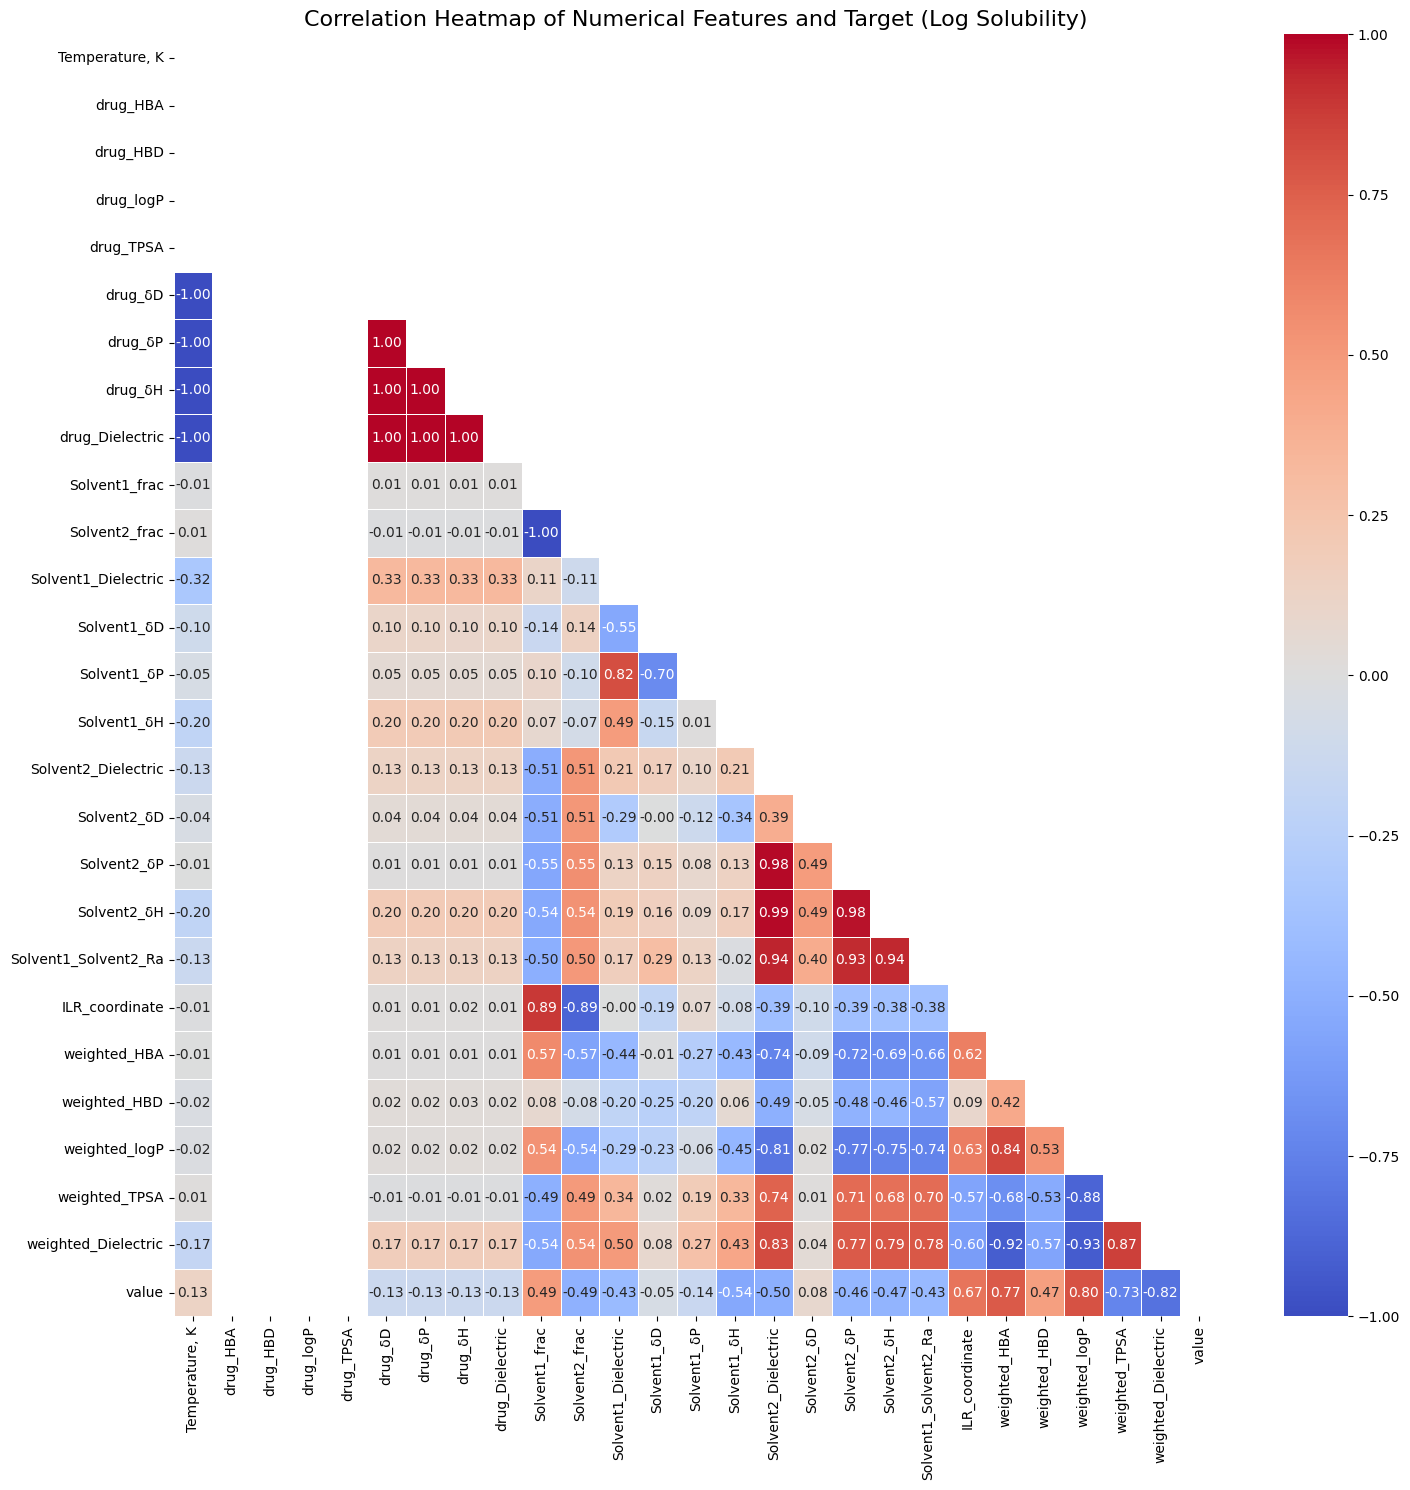


Correlation with Target Variable ('value'):
value                   1.000000
weighted_logP           0.800675
weighted_HBA            0.767912
ILR_coordinate          0.669573
Solvent1_frac           0.488742
weighted_HBD            0.469875
Temperature, K          0.126170
Solvent2_δD             0.081065
Solvent1_δD            -0.047065
drug_δH                -0.125937
drug_Dielectric        -0.126144
drug_δD                -0.126151
drug_δP                -0.126151
Solvent1_δP            -0.141411
Solvent1_Dielectric    -0.425882
Solvent1_Solvent2_Ra   -0.433548
Solvent2_δP            -0.455894
Solvent2_δH            -0.470666
Solvent2_frac          -0.488742
Solvent2_Dielectric    -0.504084
Solvent1_δH            -0.543192
weighted_TPSA          -0.730849
weighted_Dielectric    -0.822935
drug_HBA                     NaN
drug_HBD                     NaN
drug_logP                    NaN
drug_TPSA                    NaN
Name: value, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define the target variable
TARGET = 'value'

# Define numerical and molecular features (excluding fingerprints for heatmap readability)
# These are the same as used previously, without the fingerprint expansion
FEATURES_NO_FP = [
    'Temperature, K',
    'drug_HBA', 'drug_HBD', 'drug_logP', 'drug_TPSA',
    'drug_δD', 'drug_δP', 'drug_δH', 'drug_Dielectric',
    'Solvent1_frac', 'Solvent2_frac',
    'Solvent1_Dielectric', 'Solvent1_δD', 'Solvent1_δP', 'Solvent1_δH',
    'Solvent2_Dielectric', 'Solvent2_δD', 'Solvent2_δP', 'Solvent2_δH',
    'Solvent1_Solvent2_Ra',
    'ILR_coordinate',
    'weighted_HBA', 'weighted_HBD', 'weighted_logP', 'weighted_TPSA', 'weighted_Dielectric'
]

# Create a DataFrame with only the selected features and the target variable
df_selected_features = df_49[FEATURES_NO_FP + [TARGET]].copy() # Ensure df_49 is defined by running previous cells

# Impute missing values with 0 for correlation calculation (as done in models)
# This is important to ensure all values are numeric for correlation matrix
for col in df_selected_features.columns:
    if df_selected_features[col].dtype == 'object':
        # Attempt to convert to numeric, coercing errors to NaN
        df_selected_features[col] = pd.to_numeric(df_selected_features[col], errors='coerce')
    # Fill remaining NaNs (from original data or coercing) with 0
    df_selected_features[col] = df_selected_features[col].fillna(0)

# Calculate the correlation matrix
correlation_matrix = df_selected_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
plt.title('Correlation Heatmap of Numerical Features and Target (Log Solubility)', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display correlations with the target variable ('value')
print("\nCorrelation with Target Variable ('value'):")
print(correlation_matrix[TARGET].sort_values(ascending=False))


In [ ]:
#df_49['solvent_system_key'].unique()

The reason drug_HBA, drug_HBD, drug_logP, and drug_TPSA appear blank (as NaN) in the correlation matrix is because these values are constant for the entire df_49 DataFrame.

In this analysis, you've filtered df_49 to contain data exclusively for cmp_ids_drug == '[49]', which represents Flutamide. Since the drug is always Flutamide, its intrinsic molecular properties (drug_HBA, drug_HBD, drug_logP, drug_TPSA) do not change across any of the rows in df_49.

Why does this result in NaN correlation?

Correlation measures the linear relationship and co-movement between two variables. If a variable has zero variance (i.e., it never changes), there's no 'movement' or 'variation' for it to co-vary with another variable. Mathematically, the formula for correlation involves division by the standard deviation of each variable. If the standard deviation is zero, this leads to division by zero, resulting in an undefined value, which Pandas represents as NaN.

These features are important absolute properties of Flutamide, but they cannot show a correlation with other changing features or the target solubility in a dataset where the drug itself is constant.

Features dropped:
1. Solvent 1 and 2 mole fraction
They won't be used in the following machine learning process since the ILR_coordinate encapsulates the ratio of these fractions.

2. drug_HBA, drug_HBD, drug_logP, drug_TPSA
Since there is only one solute studied in this project, these features are always constant, and a machine learning model cannot learn any relationship between a constant feature and the target variable.

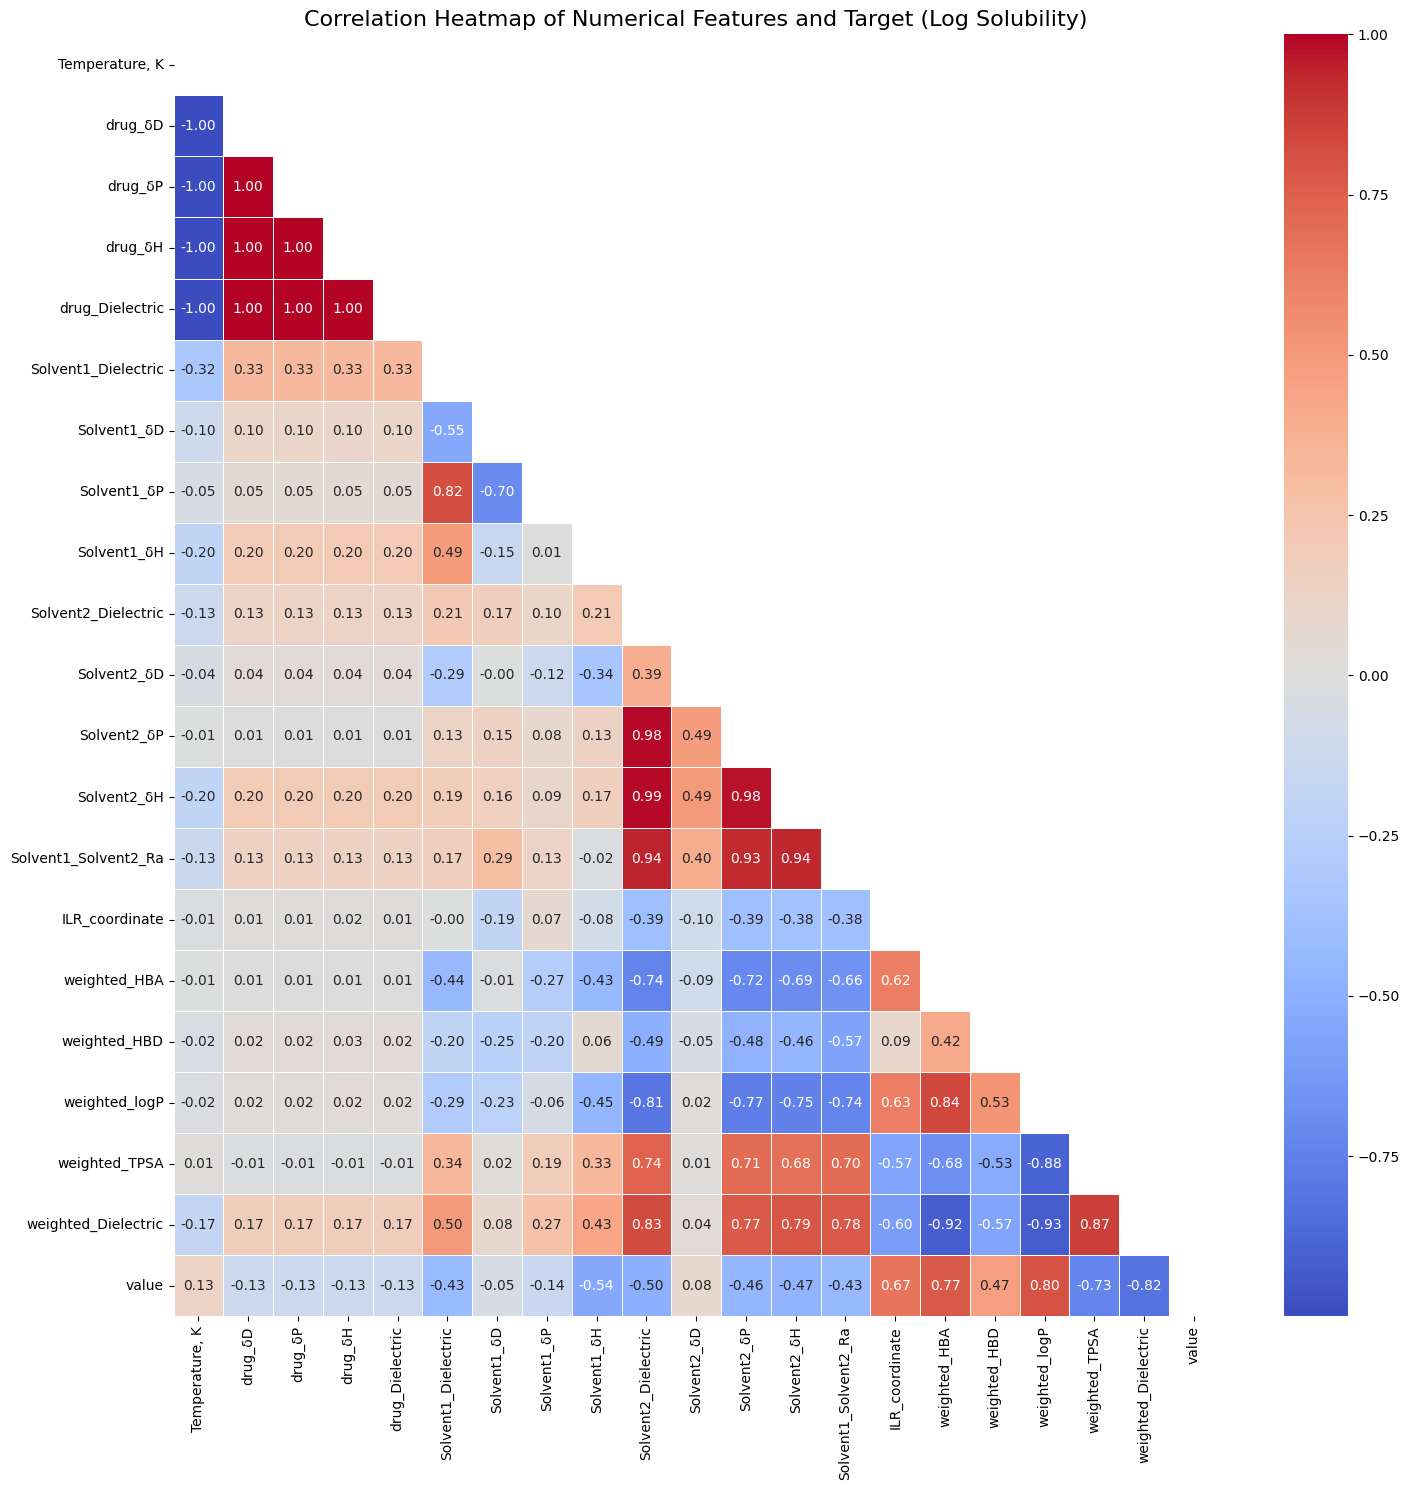


Correlation with Target Variable ('value'):
value                   1.000000
weighted_logP           0.800675
weighted_HBA            0.767912
ILR_coordinate          0.669573
weighted_HBD            0.469875
Temperature, K          0.126170
Solvent2_δD             0.081065
Solvent1_δD            -0.047065
drug_δH                -0.125937
drug_Dielectric        -0.126144
drug_δD                -0.126151
drug_δP                -0.126151
Solvent1_δP            -0.141411
Solvent1_Dielectric    -0.425882
Solvent1_Solvent2_Ra   -0.433548
Solvent2_δP            -0.455894
Solvent2_δH            -0.470666
Solvent2_Dielectric    -0.504084
Solvent1_δH            -0.543192
weighted_TPSA          -0.730849
weighted_Dielectric    -0.822935
Name: value, dtype: float64


In [ ]:
# Define the target variable
TARGET = 'value'

# These are the same as used previously, without the fingerprint expansion
FEATURES_NO_FP = [
    'Temperature, K',
    'drug_δD', 'drug_δP', 'drug_δH', 'drug_Dielectric',
    'Solvent1_Dielectric', 'Solvent1_δD', 'Solvent1_δP', 'Solvent1_δH',
    'Solvent2_Dielectric', 'Solvent2_δD', 'Solvent2_δP', 'Solvent2_δH',
    'Solvent1_Solvent2_Ra', 'ILR_coordinate',
    'weighted_HBA', 'weighted_HBD', 'weighted_logP', 'weighted_TPSA', 'weighted_Dielectric'
]

# Create a DataFrame with only the selected features and the target variable
df_selected_features = df_49[FEATURES_NO_FP + [TARGET]].copy() # Ensure df_49 is defined by running previous cells

# Impute missing values with 0 for correlation calculation (as done in models)
# This is important to ensure all values are numeric for correlation matrix
for col in df_selected_features.columns:
    if df_selected_features[col].dtype == 'object':
        # Attempt to convert to numeric, coercing errors to NaN
        df_selected_features[col] = pd.to_numeric(df_selected_features[col], errors='coerce')
    # Fill remaining NaNs (from original data or coercing) with 0
    df_selected_features[col] = df_selected_features[col].fillna(0)

# Calculate the correlation matrix
correlation_matrix = df_selected_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
plt.title('Correlation Heatmap of Numerical Features and Target (Log Solubility)', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display correlations with the target variable ('value')
print("\nCorrelation with Target Variable ('value'):")
print(correlation_matrix[TARGET].sort_values(ascending=False))


## 0.6.1 Stratified Splitting of Test & Training Datasets - Develop Stratas for Solvent Systems


In [ ]:
# Create a composite key for solvent systems
def create_solvent_system_key(row):
    s1_name = row['Solvent1_name']
    s2_name = row['Solvent2_name']

    if pd.isna(s1_name) and pd.isna(s2_name):
        return "Unknown"
    elif pd.isna(s2_name):
        return str(s1_name) # Single solvent system (Solvent1 only)
    elif pd.isna(s1_name):
        return str(s2_name) # Single solvent system (Solvent2 only)
    else:
        # For binary mixtures, sort names alphabetically for consistent keys
        sorted_names = sorted([str(s1_name), str(s2_name)])
        return f"{sorted_names[0]} - {sorted_names[1]}"

df_49['solvent_system_key'] = df_49.apply(create_solvent_system_key, axis=1)

# Display the count of unique solvent systems to verify
print("Unique Solvent Systems and their counts:")

# Store the counts of each solvent system
solvent_system_counts = df_49['solvent_system_key'].value_counts()

# Store solvent system keys and their counts in a dataframe
solvent_system_counts_df = solvent_system_counts.reset_index()
solvent_system_counts_df.columns = ['Solvent System', 'Count']
display(solvent_system_counts_df)


Unique Solvent Systems and their counts:


,Solvent System,Count
0,Ethanol - Water,90
1,2-Propanol - Water,90
2,2-Propanol - Tetrahydrofuran,90
3,Acetonitrile - Water,90
4,2-Propanol - Ethyl Acetate,90
5,2-Propanol - Acetone,90
6,"1,4-Dioxane - Water",81
7,Ethanol,10
8,2-Propanol,10
9,Acetonitrile,10


The ideal number of bins for stratification based on solubility (value column) depends on the specific distribution of your data. We want enough bins to capture meaningful variations in solubility, but not so many that some bins become too sparse, especially in the test set.

Here are some steps and considerations:

Visualize the Distribution: The best way to start is by looking at a histogram of your value column. This will show you the spread and any natural clusters or gaps in the solubility data.

General Guidelines/Rules of Thumb:

Sturges' Rule: A common rule, k = 1 + log2(n), where n is the number of data points. This gives a theoretically derived number of bins.

Square Root Rule: Another simple rule, k = sqrt(n).
Domain Knowledge: If you have specific knowledge about 'low', 'medium', 'high' solubility ranges, you might choose bins that align with these.

Practicality: Often, a starting point of 5 to 10 bins is reasonable for many datasets, which can then be adjusted after inspecting the distribution and considering the number of samples per bin.

Ensure Sufficient Samples per Bin: For StratifiedShuffleSplit to work effectively, each bin must have at least two samples (for a 80/20 train/test split, you'd ideally want more). If a bin has only one sample, it can cause issues during splitting.

## 0.6.2 Develop Flutamide Solubility Bins and Their Solubility Ranges

In [ ]:
# Number of Solubility Bins
sol_bins = 3
df_49['solubility_bins'] = pd.qcut(df_49['value'], q=sol_bins, labels=False)

print("\nDistribution of samples per solubility bin:")
print(df_49['solubility_bins'].value_counts().sort_index())


# Check if any bin has less than 2 samples (important for stratification)
min_samples_per_bin = df_49['solubility_bins'].value_counts().min()
if min_samples_per_bin < 2:
    print(f"\nWarning: At least one bin has {min_samples_per_bin} sample(s). Consider adjusting the number of bins.")

# Calculate the solubility range for each bin
# pd.cut returns the binned Series and the bin edges when retbins=True
_, bin_edges = pd.qcut(df_49['value'], q=sol_bins, labels=False, retbins=True)

print("\nSolubility Range for Each Bin:")
for i in range(len(bin_edges) - 1):
    lower_bound = bin_edges[i]
    upper_bound = bin_edges[i+1]
    print(f"Bin {i}: [{lower_bound:.4f}, {upper_bound:.4f})")


Distribution of samples per solubility bin:
solubility_bins
0    223
1    224
2    223
Name: count, dtype: int64

Solubility Range for Each Bin:
Bin 0: [-3.4316, 0.9413)
Bin 1: [0.9413, 1.6473)
Bin 2: [1.6473, 1.9039)


## 0.6.3 Develop Composite Strata Based on Solvent Systems and Flutamide Solubility

In [ ]:
# Create Composite Strata Key
df_49['composite_strat_key'] = df_49['solvent_system_key'].astype(str) + '_' + 'Sol Bin' + df_49['solubility_bins'].astype(str)
print("Distribution of samples per composite stratification key:")
composite_counts = df_49['composite_strat_key'].value_counts().sort_index()
display(composite_counts)

min_composite_samples = composite_counts.min()
if min_composite_samples < 2:
    print(f"\nWarning: At least one composite bin has {min_composite_samples} sample(s). Consider simplifying stratification or adjusting bins.")
else:
    print(f"\nMinimum samples in any composite bin: {min_composite_samples}. This should be sufficient for stratification.")


Distribution of samples per composite stratification key:


,count
composite_strat_key,
"1,4-Dioxane - Water_Sol Bin0",45
"1,4-Dioxane - Water_Sol Bin1",33
"1,4-Dioxane - Water_Sol Bin2",3
"1,4-Dioxane_Sol Bin1",4
"1,4-Dioxane_Sol Bin2",5
2-Propanol - Acetone_Sol Bin1,18
2-Propanol - Acetone_Sol Bin2,72
2-Propanol - Ethyl Acetate_Sol Bin1,38
2-Propanol - Ethyl Acetate_Sol Bin2,52



Minimum samples in any composite bin: 2. This should be sufficient for stratification.


## 0.7 Develop Baseline Model

Setting Up a Baseline for Machine Learning Models
Establishing a baseline model is a fundamental step in any machine learning project. It provides a simple, easily understandable point of comparison against which more complex models can be evaluated. Without a baseline, it's difficult to ascertain whether a sophisticated model is genuinely adding value or just performing marginally better than a trivial approach.

Here are the steps to effectively set up a baseline for your models:

1. Understand the Goal of the Baseline
The primary purpose of a baseline is to provide a lower bound on performance. If your complex model cannot outperform a simple baseline, then it's either not suitable for the task, or its implementation needs significant improvement. It helps answer the question: "Is my advanced model actually doing something useful, or could I get similar results with much less effort?"

2. Choose a Simple Model
The baseline model should be straightforward to implement, easy to interpret, and computationally inexpensive. The choice depends on the type of problem you are solving:

For Regression Tasks (like predicting solubility):

Mean/Median Predictor: Predict the average or median of the target variable for all instances. For example, always predict the average solubility of all compounds.

Simple Linear Regression: A basic statistical model that assumes a linear relationship between features and the target. This can be a good starting point if you suspect some features have direct influence.

k-Nearest Neighbors (kNN) (simple version): Predict the average of the k closest training examples. This is simple yet can capture some local patterns.
For Classification Tasks:

Majority Class Predictor: Always predict the most frequent class in the training data. For example, if 80% of your data is class 'A', always predict 'A'.
Random Predictor: Assign classes randomly, possibly weighted by the class distribution in the training data.

Logistic Regression: A simple and interpretable model for binary or multi-class classification.
For Time Series Tasks:

Last Value Predictor: Predict that the next value will be the same as the last observed value.
Moving Average: Predict the average of the last n observed values.

3. Establish Evaluation Metrics
Use the exact same evaluation metrics for your baseline model that you intend to use for your more complex models. This ensures a fair comparison.

For Regression: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), R-squared (R2).
For Classification: Accuracy, Precision, Recall, F1-score, ROC-AUC.

4. Minimal Data Preprocessing
Apply only the most essential and universally applicable preprocessing steps that are required for your simple baseline model to run. Avoid complex feature engineering, advanced scaling, or dimensionality reduction techniques at this stage. These more involved steps are typically part of the pipeline for your advanced models, and you don't want the baseline's performance to be inflated by sophisticated preprocessing that isn't truly part of the baseline model itself.

5. Train and Evaluate the Baseline
Train your chosen simple model on your training data and evaluate its performance on a separate validation or test set using the established metrics. It's crucial to use the same data splitting strategy (e.g., train-test split, cross-validation) for your baseline as you will for your more complex models to ensure a fair comparison.

6. Compare and Iterate
Once you have the baseline's performance metrics, you have a benchmark. Any more complex model you develop must significantly outperform this baseline to be considered valuable. If a complex model performs worse or only marginally better than the baseline, it's a strong indicator that you need to re-evaluate your approach, features, or model choice.

7. Document the Baseline
Clearly document the baseline model, its performance, and the reasoning behind its selection. This documentation serves as a reference point throughout your project and helps communicate the value added by more advanced models.

In [ ]:
# linear model
from sklearn.linear_model import LinearRegression

# model selection
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
# Conduct stratified splitting based on composite strata
from sklearn.model_selection import train_test_split

train_size = 0.8
test_size = 1-train_size

df_train_baseline, df_test_baseline = train_test_split(
    df_49,
    train_size = train_size,
    test_size = test_size,
    random_state = RANDOM_SEED,
    stratify = df_49['composite_strat_key']
)

In [ ]:
from sklearn.impute import SimpleImputer # Import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize the Linear Regression model
linear_regressor = LinearRegression()

# Define the target variable
TARGET = 'value'

# Define numerical and molecular features (copied from ML model cells for self-containment)
FEATURES = [
    'Temperature, K',
    'drug_δD', 'drug_δP', 'drug_δH', 'drug_Dielectric',
    'Solvent1_Dielectric', 'Solvent1_δD', 'Solvent1_δP', 'Solvent1_δH',
    'Solvent2_Dielectric', 'Solvent2_δD', 'Solvent2_δP', 'Solvent2_δH',
    'Solvent1_Solvent2_Ra', 'ILR_coordinate',
    'weighted_HBA', 'weighted_HBD', 'weighted_logP', 'weighted_TPSA', 'weighted_Dielectric'
]

# Instantiate SimpleImputer with a strategy ( fill with 0)
imputer = SimpleImputer(strategy='constant', fill_value=0)

# Apply imputation to training and test features
X_train_imputed = imputer.fit_transform(df_train_baseline[FEATURES])
X_test_imputed = imputer.transform(df_test_baseline[FEATURES])

# Train the baseline model on the imputed training data
linear_regressor.fit(X_train_imputed, df_train_baseline[TARGET])

# Test the baseline model on the imputed training data
y_pred_train_baseline = linear_regressor.predict(X_train_imputed)

# Test the baseline model on the imputed test data
y_pred_test_baseline = linear_regressor.predict(X_test_imputed)

# Evaluate the model performance on the training and test datasets
# Calculate and print metrics for training data
baseline_train_mae = mean_absolute_error(df_train_baseline[TARGET], y_pred_train_baseline)
baseline_train_mse = mean_squared_error(df_train_baseline[TARGET], y_pred_train_baseline)
baseline_train_rmse = np.sqrt(baseline_train_mse)
baseline_train_r2 = r2_score(df_train_baseline[TARGET], y_pred_train_baseline)

print("Linear Regressor Baseline - Training Metrics:")
print(f"  MAE: {baseline_train_mae:.4f}")
print(f"  MSE: {baseline_train_mse:.4f}")
print(f"  RMSE: {baseline_train_rmse:.4f}")
print(f"  R2: {baseline_train_r2:.4f}")

# Calculate and print metrics for test data
baseline_test_mae = mean_absolute_error(df_test_baseline[TARGET], y_pred_test_baseline)
baseline_test_mse = mean_squared_error(df_test_baseline[TARGET], y_pred_test_baseline)
baseline_test_rmse = np.sqrt(baseline_test_mse)
baseline_test_r2 = r2_score(df_test_baseline[TARGET], y_pred_test_baseline)

print("\nLinear Regressor Baseline - Test Metrics:")
print(f"  MAE: {baseline_test_mae:.4f}")
print(f"  MSE: {baseline_test_mse:.4f}")
print(f"  RMSE: {baseline_test_rmse:.4f}")
print(f"  R2: {baseline_test_r2:.4f}")

Linear Regressor Baseline - Training Metrics:
  MAE: 0.2448
  MSE: 0.1083
  RMSE: 0.3291
  R2: 0.9228

Linear Regressor Baseline - Test Metrics:
  MAE: 0.2530
  MSE: 0.1171
  RMSE: 0.3422
  R2: 0.9055


A simple linear regression model is trained and used as the baseline model to obtain a lower bound of machine learning model performance

## 1.1 Stratified Splitting Based on Solvent System Keys - Random Forest Regression

In [ ]:
from sklearn.model_selection import train_test_split

test_size = 0.2
train_size = 1-test_size

df_train_solsys_stratified, df_test_solsys_stratified = train_test_split(
    df_49,
    train_size = train_size,
    test_size = test_size,
    random_state = RANDOM_SEED,
    stratify = df_49['solvent_system_key']
)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define the target variable
TARGET = 'value'

# Define numerical and molecular features (copied from ML model cells for self-containment)
FEATURES = [
    'Temperature, K',
    'drug_δD', 'drug_δP', 'drug_δH', 'drug_Dielectric',
    'Solvent1_Dielectric', 'Solvent1_δD', 'Solvent1_δP', 'Solvent1_δH',
    'Solvent2_Dielectric', 'Solvent2_δD', 'Solvent2_δP', 'Solvent2_δH',
    'Solvent1_Solvent2_Ra', 'ILR_coordinate',
    'weighted_HBA', 'weighted_HBD', 'weighted_logP', 'weighted_TPSA', 'weighted_Dielectric'
]

X_train = df_train_solsys_stratified[FEATURES]
y_train = df_train_solsys_stratified[TARGET]
X_test = df_test_solsys_stratified[FEATURES]
y_test = df_test_solsys_stratified[TARGET]

# 1. Instantiate SimpleImputer
imputer = SimpleImputer(strategy='constant', fill_value=0)

# 2. Instantiate RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)

# 3. Create a Pipeline named rf_pipeline
rf_pipeline = Pipeline([
    ('imputer', imputer),
    ('regressor', rf_regressor)
])

# 4. Fit the rf_pipeline to X_train and y_train
rf_pipeline.fit(X_train, y_train)

# 5. Make predictions on the training data
y_pred_rf_train = rf_pipeline.predict(X_train)

# 6. Make predictions on the test data
y_pred_rf_test = rf_pipeline.predict(X_test)

# 7. Calculate and print metrics for training data
rf_train_mae = mean_absolute_error(y_train, y_pred_rf_train)
rf_train_mse = mean_squared_error(y_train, y_pred_rf_train)
rf_train_rmse = np.sqrt(rf_train_mse)
rf_train_r2 = r2_score(y_train, y_pred_rf_train)

print("Random Forest Regressor - Training Metrics:")
print(f"  MAE: {rf_train_mae:.4f}")
print(f"  MSE: {rf_train_mse:.4f}")
print(f"  RMSE: {rf_train_rmse:.4f}")
print(f"  R2: {rf_train_r2:.4f}")

# 8. Calculate and print metrics for test data
rf_test_mae = mean_absolute_error(y_test, y_pred_rf_test)
rf_test_mse = mean_squared_error(y_test, y_pred_rf_test)
rf_test_rmse = np.sqrt(rf_test_mse)
rf_test_r2 = r2_score(y_test, y_pred_rf_test)

print("\nRandom Forest Regressor - Test Metrics:")
print(f"  MAE: {rf_test_mae:.4f}")
print(f"  MSE: {rf_test_mse:.4f}")
print(f"  RMSE: {rf_test_rmse:.4f}")
print(f"  R2: {rf_test_r2:.4f}")

Random Forest Regressor - Training Metrics:
  MAE: 0.0142
  MSE: 0.0005
  RMSE: 0.0219
  R2: 0.9996

Random Forest Regressor - Test Metrics:
  MAE: 0.0364
  MSE: 0.0029
  RMSE: 0.0538
  R2: 0.9981


## 1.2 Stratified Splitting Based on Solvent System Keys - XGBoost Regression

In [ ]:
import xgboost as xgb

# 1. Instantiate SimpleImputer (already imported, using the same settings)
imputer = SimpleImputer(strategy='constant', fill_value=0)

# 2. Instantiate XGBoostRegressor
xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror', # Objective for regression tasks
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

# 3. Create a Pipeline named xgb_pipeline
xgb_pipeline = Pipeline([
    ('imputer', imputer),
    ('regressor', xgb_regressor)
])

# 4. Fit the xgb_pipeline to X_train and y_train
xgb_pipeline.fit(X_train, y_train)

# 5. Make predictions on the training data
y_pred_xgb_train = xgb_pipeline.predict(X_train)

# 6. Make predictions on the test data
y_pred_xgb_test = xgb_pipeline.predict(X_test)

# 7. Calculate and print metrics for training data
xgb_train_mae = mean_absolute_error(y_train, y_pred_xgb_train)
xgb_train_mse = mean_squared_error(y_train, y_pred_xgb_train)
xgb_train_rmse = np.sqrt(xgb_train_mse)
xgb_train_r2 = r2_score(y_train, y_pred_xgb_train)

print("XGBoost Regressor - Training Metrics:")
print(f"  MAE: {xgb_train_mae:.4f}")
print(f"  MSE: {xgb_train_mse:.4f}")
print(f"  RMSE: {xgb_train_rmse:.4f}")
print(f"  R2: {xgb_train_r2:.4f}")

# 8. Calculate and print metrics for test data
xgb_test_mae = mean_absolute_error(y_test, y_pred_xgb_test)
xgb_test_mse = mean_squared_error(y_test, y_pred_xgb_test)
xgb_test_rmse = np.sqrt(xgb_test_mse)
xgb_test_r2 = r2_score(y_test, y_pred_xgb_test)

print("\nXGBoost Regressor - Test Metrics:")
print(f"  MAE: {xgb_test_mae:.4f}")
print(f"  MSE: {xgb_test_mse:.4f}")
print(f"  RMSE: {xgb_test_rmse:.4f}")
print(f"  R2: {xgb_test_r2:.4f}")

XGBoost Regressor - Training Metrics:
  MAE: 0.0075
  MSE: 0.0001
  RMSE: 0.0098
  R2: 0.9999

XGBoost Regressor - Test Metrics:
  MAE: 0.0345
  MSE: 0.0026
  RMSE: 0.0512
  R2: 0.9983


## 2.1 Stratified Splitting Based on Solubility Bins - Random Forest Regression

In [ ]:
from sklearn.model_selection import train_test_split

test_size = 0.2
train_size = 1-test_size

df_train_sol_stratified, df_test_sol_stratified = train_test_split(
    df_49,
    train_size = train_size,
    test_size = test_size,
    random_state = RANDOM_SEED,
    stratify = df_49['solubility_bins']
)

In [ ]:
X_train = df_train_sol_stratified[FEATURES]
y_train = df_train_sol_stratified[TARGET]
X_test = df_test_sol_stratified[FEATURES]
y_test = df_test_sol_stratified[TARGET]

# 1. Instantiate SimpleImputer
imputer = SimpleImputer(strategy='constant', fill_value=0)

# 2. Instantiate RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)

# 3. Create a Pipeline named rf_pipeline
rf_pipeline = Pipeline([
    ('imputer', imputer),
    ('regressor', rf_regressor)
])

# 4. Fit the rf_pipeline to X_train and y_train
rf_pipeline.fit(X_train, y_train)

# 5. Make predictions on the training data
y_pred_rf_train = rf_pipeline.predict(X_train)

# 6. Make predictions on the test data
y_pred_rf_test = rf_pipeline.predict(X_test)

# 7. Calculate and print metrics for training data
rf_train_mae = mean_absolute_error(y_train, y_pred_rf_train)
rf_train_mse = mean_squared_error(y_train, y_pred_rf_train)
rf_train_rmse = np.sqrt(rf_train_mse)
rf_train_r2 = r2_score(y_train, y_pred_rf_train)

print("Random Forest Regressor - Training Metrics:")
print(f"  MAE: {rf_train_mae:.4f}")
print(f"  MSE: {rf_train_mse:.4f}")
print(f"  RMSE: {rf_train_rmse:.4f}")
print(f"  R2: {rf_train_r2:.4f}")

# 8. Calculate and print metrics for test data
rf_test_mae = mean_absolute_error(y_test, y_pred_rf_test)
rf_test_mse = mean_squared_error(y_test, y_pred_rf_test)
rf_test_rmse = np.sqrt(rf_test_mse)
rf_test_r2 = r2_score(y_test, y_pred_rf_test)

print("\nRandom Forest Regressor - Test Metrics:")
print(f"  MAE: {rf_test_mae:.4f}")
print(f"  MSE: {rf_test_mse:.4f}")
print(f"  RMSE: {rf_test_rmse:.4f}")
print(f"  R2: {rf_test_r2:.4f}")

Random Forest Regressor - Training Metrics:
  MAE: 0.0140
  MSE: 0.0005
  RMSE: 0.0218
  R2: 0.9997

Random Forest Regressor - Test Metrics:
  MAE: 0.0388
  MSE: 0.0035
  RMSE: 0.0590
  R2: 0.9975


## 2.2 Stratified Splitting Based on Solubility Bins - XGBoost Regression

In [ ]:
# 1. Instantiate SimpleImputer (already imported, using the same settings)
imputer = SimpleImputer(strategy='constant', fill_value=0)

# 2. Instantiate XGBoostRegressor
xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror', # Objective for regression tasks
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

# 3. Create a Pipeline named xgb_pipeline
xgb_pipeline = Pipeline([
    ('imputer', imputer),
    ('regressor', xgb_regressor)
])

# 4. Fit the xgb_pipeline to X_train and y_train
xgb_pipeline.fit(X_train, y_train)

# 5. Make predictions on the training data
y_pred_xgb_train = xgb_pipeline.predict(X_train)

# 6. Make predictions on the test data
y_pred_xgb_test = xgb_pipeline.predict(X_test)

# 7. Calculate and print metrics for training data
xgb_train_mae = mean_absolute_error(y_train, y_pred_xgb_train)
xgb_train_mse = mean_squared_error(y_train, y_pred_xgb_train)
xgb_train_rmse = np.sqrt(xgb_train_mse)
xgb_train_r2 = r2_score(y_train, y_pred_xgb_train)

print("XGBoost Regressor - Training Metrics:")
print(f"  MAE: {xgb_train_mae:.4f}")
print(f"  MSE: {xgb_train_mse:.4f}")
print(f"  RMSE: {xgb_train_rmse:.4f}")
print(f"  R2: {xgb_train_r2:.4f}")

# 8. Calculate and print metrics for test data
xgb_test_mae = mean_absolute_error(y_test, y_pred_xgb_test)
xgb_test_mse = mean_squared_error(y_test, y_pred_xgb_test)
xgb_test_rmse = np.sqrt(xgb_test_mse)
xgb_test_r2 = r2_score(y_test, y_pred_xgb_test)

print("\nXGBoost Regressor - Test Metrics:")
print(f"  MAE: {xgb_test_mae:.4f}")
print(f"  MSE: {xgb_test_mse:.4f}")
print(f"  RMSE: {xgb_test_rmse:.4f}")
print(f"  R2: {xgb_test_r2:.4f}")

XGBoost Regressor - Training Metrics:
  MAE: 0.0075
  MSE: 0.0001
  RMSE: 0.0100
  R2: 0.9999

XGBoost Regressor - Test Metrics:
  MAE: 0.0316
  MSE: 0.0021
  RMSE: 0.0457
  R2: 0.9985


## 3.1 Stratified Splitting Based on Composite Strata - Random Forest Regression

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer # New import for imputation
from sklearn.pipeline import Pipeline # New import for pipelines

In [ ]:
# Define the target variable
TARGET = 'value'

# Define numerical and molecular features (copied from ML model cells for self-containment)
FEATURES = [
    'Temperature, K',
    'drug_δD', 'drug_δP', 'drug_δH', 'drug_Dielectric',
    'Solvent1_Dielectric', 'Solvent1_δD', 'Solvent1_δP', 'Solvent1_δH',
    'Solvent2_Dielectric', 'Solvent2_δD', 'Solvent2_δP', 'Solvent2_δH',
    'Solvent1_Solvent2_Ra', 'ILR_coordinate',
    'weighted_HBA', 'weighted_HBD', 'weighted_logP', 'weighted_TPSA', 'weighted_Dielectric'
]

# Assuming fp_size is available from previous cells, or define it here
fp_size = 2048 # Ensure this matches the size used in 'weighted_fp' creation

def prepare_data_for_ml(df, features, fp_column='weighted_fp', fp_size=2048):
    # Extract numerical features
    X_num = df[features].copy()

    # Expand fingerprint column into individual columns
    # Ensure fingerprints are not None before converting to list
    fp_data = df[fp_column].apply(lambda x: list(x) if x is not None else [0.0] * fp_size).tolist()
    X_fp = pd.DataFrame(fp_data, index=df.index, columns=[f'fp_{i}' for i in range(fp_size)])

    # Concatenate all features
    X = pd.concat([X_num, X_fp], axis=1)
    y = df[TARGET]
    return X, y

# Prepare the full dataset for machine learning
X, y = prepare_data_for_ml(df_49, FEATURES, fp_size=fp_size)

# --- Perform single train-test split based on composite strata ---
test_size = 0.2
train_size = 1 - test_size

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=RANDOM_SEED,
    stratify=df_49['composite_strat_key'] # Stratify using the composite key from df_49
)

# --- Train and Evaluate Random Forest Regressor ---
print("\n--- Random Forest Regressor (Composite Stratification) ---")

# 1. Instantiate SimpleImputer
imputer = SimpleImputer(strategy='constant', fill_value=0)

# 2. Instantiate RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)

# 3. Create a Pipeline named rf_pipeline
rf_pipeline = Pipeline([
    ('imputer', imputer),
    ('regressor', rf_regressor)
])

# 4. Fit the rf_pipeline to X_train and y_train
rf_pipeline.fit(X_train, y_train)

# 5. Make predictions on the training data
y_pred_rf_train = rf_pipeline.predict(X_train)

# 6. Make predictions on the test data
y_pred_rf_test = rf_pipeline.predict(X_test)

# 7. Calculate and print metrics for training data
rf_train_mae = mean_absolute_error(y_train, y_pred_rf_train)
rf_train_mse = mean_squared_error(y_train, y_pred_rf_train)
rf_train_rmse = np.sqrt(rf_train_mse)
rf_train_r2 = r2_score(y_train, y_pred_rf_train)

print("Random Forest Regressor - Training Metrics:")
print(f"  MAE: {rf_train_mae:.4f}")
print(f"  MSE: {rf_train_mse:.4f}")
print(f"  RMSE: {rf_train_rmse:.4f}")
print(f"  R2: {rf_train_r2:.4f}")

# 8. Calculate and print metrics for test data
rf_test_mae = mean_absolute_error(y_test, y_pred_rf_test)
rf_test_mse = mean_squared_error(y_test, y_pred_rf_test)
rf_test_rmse = np.sqrt(rf_test_mse)
rf_test_r2 = r2_score(y_test, y_pred_rf_test)

print("\nRandom Forest Regressor - Test Metrics:")
print(f"  MAE: {rf_test_mae:.4f}")
print(f"  MSE: {rf_test_mse:.4f}")
print(f"  RMSE: {rf_test_rmse:.4f}")
print(f"  R2: {rf_test_r2:.4f}")



--- Random Forest Regressor (Composite Stratification) ---
Random Forest Regressor - Training Metrics:
  MAE: 0.0128
  MSE: 0.0004
  RMSE: 0.0198
  R2: 0.9997

Random Forest Regressor - Test Metrics:
  MAE: 0.0352
  MSE: 0.0032
  RMSE: 0.0569
  R2: 0.9974


## 3.2 Stratified Splitting Based on Composite Strata - XGBoost Regression

In [ ]:
test_size = 0.2
train_size = 1 - test_size

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=RANDOM_SEED,
    stratify=df_49['composite_strat_key'] # Stratify using the composite key from df_49
)

# --- Train and Evaluate XGBoost Regressor ---
print("\n--- XGBoost Regressor ( Composite Stratification) ---")

# 1. Instantiate SimpleImputer
imputer = SimpleImputer(strategy='constant', fill_value=0)

# 2. Instantiate XGBoostRegressor
xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

# 3. Create a Pipeline named xgb_pipeline
xgb_pipeline = Pipeline([
    ('imputer', imputer),
    ('regressor', xgb_regressor)
])

# 4. Fit the xgb_pipeline to X_train and y_train
xgb_pipeline.fit(X_train, y_train)

# 5. Make predictions on the training data
y_pred_xgb_train = xgb_pipeline.predict(X_train)

# 6. Make predictions on the test data
y_pred_xgb_test = xgb_pipeline.predict(X_test)

# 7. Calculate and print metrics for training data
xgb_train_mae = mean_absolute_error(y_train, y_pred_xgb_train)
xgb_train_mse = mean_squared_error(y_train, y_pred_xgb_train)
xgb_train_rmse = np.sqrt(xgb_train_mse)
xgb_train_r2 = r2_score(y_train, y_pred_xgb_train)

print("XGBoost Regressor - Training Metrics:")
print(f"  MAE: {xgb_train_mae:.4f}")
print(f"  MSE: {xgb_train_mse:.4f}")
print(f"  RMSE: {xgb_train_rmse:.4f}")
print(f"  R2: {xgb_train_r2:.4f}")

# 8. Calculate and print metrics for test data
xgb_test_mae = mean_absolute_error(y_test, y_pred_xgb_test)
xgb_test_mse = mean_squared_error(y_test, y_pred_xgb_test)
xgb_test_rmse = np.sqrt(xgb_test_mse)
xgb_test_r2 = r2_score(y_test, y_pred_xgb_test)

print("\nXGBoost Regressor - Test Metrics:")
print(f"  MAE: {xgb_test_mae:.4f}")
print(f"  MSE: {xgb_test_mse:.4f}")
print(f"  RMSE: {xgb_test_rmse:.4f}")
print(f"  R2: {xgb_test_r2:.4f}")



--- XGBoost Regressor ( Composite Stratification) ---
XGBoost Regressor - Training Metrics:
  MAE: 0.0077
  MSE: 0.0001
  RMSE: 0.0100
  R2: 0.9999

XGBoost Regressor - Test Metrics:
  MAE: 0.0279
  MSE: 0.0018
  RMSE: 0.0419
  R2: 0.9986


## Purposes of Implementing Pipeline

Imagine you have a series of steps you need to perform on your data before it goes into your machine learning model. For example, first you might need to fill in missing values (imputation), then scale your numerical features, and finally train your regression model.

A Pipeline in scikit-learn is essentially a way to chain these multiple processing steps and a final estimator (like your Random Forest or XGBoost model) together into a single, cohesive object.

What it does:

Simplifies Workflow:
It streamlines your code by letting you define all your preprocessing and modeling steps in one go. Instead of manually applying each step one after the other (imputer.fit_transform(X_train), then scaler.fit_transform(X_train), etc.), the pipeline handles the order for you.

Encapsulates Steps:
It treats the entire sequence of operations as a single step. When you call .fit() on the pipeline, it sequentially calls .fit_transform() on all but the last estimator, and then .fit() on the final estimator (your model). When you call .predict() or .transform() on the pipeline, it sequentially calls .transform() on all but the last estimator, and then .predict() or .transform() on the final estimator.

Crucially, Prevents Data Leakage:
This is where Pipelines shine in cross-validation. When you train a Pipeline within each fold of a cross-validation:

1. The fit() method of each preprocessing step within the pipeline (like your SimpleImputer) is called only on the training data of that specific fold (X_train_fold).

2. Then, the transform() method of those preprocessing steps is applied to both the training data (X_train_fold) and the test data (X_test_fold) of that same fold.

This ensures that the preprocessing steps learn nothing from the test data. The statistics (like how to fill missing values, or what scaling parameters to use) are derived only from the training set, just as they would be if you were processing completely new, unseen data in a real-world scenario. This is the mechanism by which it prevents data leakage.

In our case, your rf_pipeline and xgb_pipeline are defined as:

rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('regressor', RandomForestRegressor(...))
])

When rf_pipeline.fit(X_train_fold, y_train_fold) is called:

1. The SimpleImputer learns (in this specific case, it just takes note of its fill_value=0 strategy) only from X_train_fold.

2. X_train_fold then gets its missing values filled by the SimpleImputer using that strategy.

3. Finally, the RandomForestRegressor is trained on this imputed X_train_fold.

When rf_pipeline.predict(X_test_fold) is called:

1. X_test_fold first goes through the same SimpleImputer that was fit on X_train_fold, and its missing values are filled.

2. Then, this imputed X_test_fold is passed to the trained RandomForestRegressor to make predictions.

This sequence guarantees that your test data remains completely 'unseen' during the preprocessing learning phase of each fold, giving you a much more honest and reliable evaluation of your model's performance.

## Analysis for Overfitting:

For both models, the Mean Train R2 is extremely high (0.9997 for RF, 0.9999 for XGBoost), while the Mean Test R2 is also very high but slightly lower (0.9981 for RF, 0.9987 for XGBoost). Similarly, the Train MAE and RMSE are considerably lower than their Test counterparts.

This difference between training performance and test performance indicates that both models are exhibiting a mild degree of overfitting. They have learned the training data (including some of its noise) very well, leading to near-perfect scores on the training set. However, when presented with unseen data (the test sets), their performance, while still excellent, drops slightly.

## Key Observations and Interpretation from Feature Importance Analysis:

Dominance of weighted_HBA:
For both Random Forest and XGBoost, the weighted_HBA feature (mole fraction weighted Hydrogen Bond Acceptors of the solvent mixture) is overwhelmingly the most important feature, contributing over 90% of the importance. This indicates that the ability of the solvent system to accept hydrogen bonds is the primary driver for flutamide's solubility in these models.

Other Important Features:
After weighted_HBA, other weighted molecular descriptors like weighted_TPSA (Total Polar Surface Area), weighted_Dielectric (Dielectric constant), and weighted_logP also show up as important. This makes sense as these properties heavily influence intermolecular interactions and solvent polarity, which are critical for solubility.

Individual Solvent Contributions:
While the weighted features are dominant, you can also see individual solvent properties like Solvent1_δH, Solvent2_Dielectric, and Solvent1_Dielectric appearing in the top ranks. This shows that specific properties of the individual solvents (especially related to hydrogen bonding and polarity) play a role, even after accounting for their weighted average.

Temperature's Role:
Temperature, K appears in the top 10 for both models, indicating its expected influence on solubility, though its importance is relatively small compared to weighted_HBA.

Fingerprints (Sparsity):
For XGBoost, you see fp_80 (a specific bit from the Morgan fingerprint) appear in the top 10. This indicates that while the overall fingerprint space is vast (2048 bits), some specific structural features captured by certain bits can still be relevant. However, given the many fingerprint features (2048 of them), their individual importance will naturally be lower than consolidated physical properties.

What this means for your project:

Your models are heavily relying on weighted_HBA and other weighted solvent properties, which is chemically intuitive for solubility prediction. This suggests the models are learning physically meaningful relationships.
You could potentially explore feature reduction by experimenting with removing very low-importance features (e.g., many of the individual fingerprint bits if they consistently have near-zero importance), though given the excellent performance, this might not be strictly necessary for improving accuracy, but could simplify the models or speed up training slightly.
This feature importance analysis confirms that your engineered features are highly relevant and your models are learning coherent patterns from the data.

## 4.1 Hyperparameter Tunning by Randomized Search CV - XGBoost Model

In [ ]:
from sklearn.model_selection import GridSearchCV, GroupKFold, RandomizedSearchCV # Added RandomizedSearchCV

# Re-using previously defined FEATURES, TARGET, X, y from K-fold CV setup
# X and y already include both numerical features and expanded fingerprint features

# Define the parameter distributions for RandomizedSearchCV for XGBoost
# This is a basic example; more parameters can be tuned
param_grid = {
    'regressor__n_estimators': [50, 100, 200], # Number of boosting rounds
    'regressor__learning_rate': [0.01, 0.1, 0.2], # Step size shrinkage to prevent overfitting
    'regressor__max_depth': [3, 5, 7], # Maximum depth of a tree
    'regressor__subsample': [0.8, 1.0], # Subsample ratio of the training instance
    'regressor__colsample_bytree': [0.8, 1.0] # Subsample ratio of columns when constructing each tree
}

# Initialize XGBoost Regressor with a fixed random state
xgb_regressor_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=RANDOM_SEED,
    n_jobs=-1 # Use all available cores
)

# Create a pipeline with imputer and the base XGBoost regressor
# The imputer must be part of the pipeline to prevent data leakage during CV
xgb_pipeline_grid = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('regressor', xgb_regressor_base)
])

# Initialize RandomizedSearchCV
# We'll use GroupKFold to stratify by 'composite_strat_key' for regression
# n_iter specifies the number of parameter settings that are sampled
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_pipeline_grid,
    param_distributions=param_grid, # Changed to param_distributions for RandomizedSearchCV
    n_iter=30, # Number of parameter settings that are sampled
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'], # Optimize for MAE
    refit='neg_mean_absolute_error', # Explicitly specify the metric for refitting
    cv=GroupKFold(n_splits=5), # Use GroupKFold
    verbose=2, # Output progress
    random_state=RANDOM_SEED, # For reproducibility of the random sampling
    n_jobs=-1 # Use all available cores
)

print("Starting RandomizedSearchCV for XGBoost...")
# Fit RandomizedSearchCV on the entire dataset (X, y) using 'composite_strat_key' for grouping
random_search_xgb.fit(X, y, groups=df_49['composite_strat_key'])

print("RandomizedSearchCV finished.")

# Get the best parameters and best score
best_params_xgb = random_search_xgb.best_params_
best_score_xgb = -random_search_xgb.best_score_ # Convert negative MAE back to positive

print("\nBest parameters found for XGBoost:")
for param, value in best_params_xgb.items():
    print(f"  {param}: {value}")

print(f"Best Mean Absolute Error (MAE) from CV for XGBoost: {best_score_xgb:.4f}")

# You can also get the best estimator (the trained model with best parameters)
best_xgb_model = random_search_xgb.best_estimator_

# To see the performance of the best model on the full dataset:
y_pred_best_xgb_train = best_xgb_model.predict(X)
print("\nPerformance of the best XGBoost model on the full dataset:")
print(f"  MAE: {mean_absolute_error(y, y_pred_best_xgb_train):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y, y_pred_best_xgb_train)):.4f}")
print(f"  R2: {r2_score(y, y_pred_best_xgb_train):.4f}")

Starting RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
RandomizedSearchCV finished.

Best parameters found for XGBoost:
  regressor__subsample: 1.0
  regressor__n_estimators: 200
  regressor__max_depth: 3
  regressor__learning_rate: 0.2
  regressor__colsample_bytree: 1.0
Best Mean Absolute Error (MAE) from CV for XGBoost: 0.1242

Performance of the best XGBoost model on the full dataset:
  MAE: 0.0080
  RMSE: 0.0111
  R2: 0.9999


## 4.2 Hyperparameter Tunning by Randomized Search CV - Random Forest Model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GroupKFold

# Re-using previously defined RANDOM_SEED, FEATURES, TARGET, X, y, df_49

# Define the parameter distributions for RandomizedSearchCV for Random Forest
param_distributions_rf = {
    'regressor__n_estimators': [50, 100, 200, 300], # Number of trees in the forest
    'regressor__max_depth': [None, 10, 20, 30], # Maximum depth of the tree
    'regressor__min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'regressor__min_samples_leaf': [1, 2, 4], # Minimum number of samples required to be at a leaf node
    'regressor__max_features': [1.0, 'sqrt', 'log2'] # Number of features to consider when looking for the best split
}

# Initialize Random Forest Regressor with a fixed random state
rf_regressor_base = RandomForestRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1 # Use all available cores
)

# Create a pipeline with imputer and the base Random Forest regressor
rf_pipeline_random_search = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('regressor', rf_regressor_base)
])

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_pipeline_random_search,
    param_distributions=param_distributions_rf,
    n_iter=30, # Number of parameter settings that are sampled (adjust as needed)
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'], # Optimize for MAE
    refit='neg_mean_absolute_error', # Explicitly specify the metric for refitting
    cv=GroupKFold(n_splits=5), # Use GroupKFold for stratification
    verbose=2, # Output progress
    random_state=RANDOM_SEED, # For reproducibility of the random sampling
    n_jobs=-1 # Use all available cores
)

print("Starting RandomizedSearchCV for Random Forest...")
# Fit RandomizedSearchCV on the entire dataset (X, y) using 'composite_strat_key' for grouping
random_search_rf.fit(X, y, groups=df_49['composite_strat_key'])

print("RandomizedSearchCV for Random Forest finished.")

# Get the best parameters and best score
best_params_rf = random_search_rf.best_params_
best_score_rf = -random_search_rf.best_score_ # Convert negative MAE back to positive

print("\nBest parameters found for Random Forest:")
for param, value in best_params_rf.items():
    print(f"  {param}: {value}")

print(f"Best Mean Absolute Error (MAE) from CV for Random Forest: {best_score_rf:.4f}")

# Get the best estimator (the trained model with best parameters)
best_rf_model = random_search_rf.best_estimator_

# To see the performance of the best model on the full dataset:
y_pred_best_rf_train = best_rf_model.predict(X)
print("\nPerformance of the best Random Forest model on the full dataset:")
print(f"  MAE: {mean_absolute_error(y, y_pred_best_rf_train):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y, y_pred_best_rf_train)):.4f}")
print(f"  R2: {r2_score(y, y_pred_best_rf_train):.4f}")

Starting RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
RandomizedSearchCV for Random Forest finished.

Best parameters found for Random Forest:
  regressor__n_estimators: 100
  regressor__min_samples_split: 2
  regressor__min_samples_leaf: 1
  regressor__max_features: 1.0
  regressor__max_depth: 30
Best Mean Absolute Error (MAE) from CV for Random Forest: 0.1782

Performance of the best Random Forest model on the full dataset:
  MAE: 0.0111
  RMSE: 0.0170
  R2: 0.9998


## 5.1 SHAP Analysis - XGBoost Model


Generating SHAP summary plot (Beeswarm)...


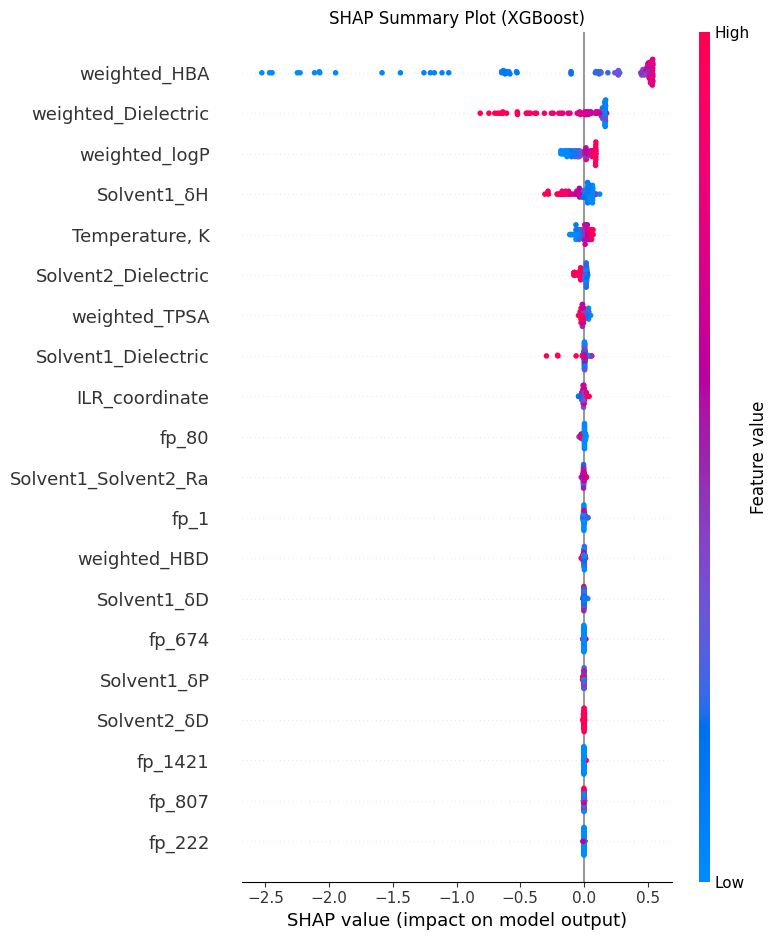


Generating SHAP force plot for a sample prediction (instance 0)...



Generating SHAP bar plot for global feature importance...


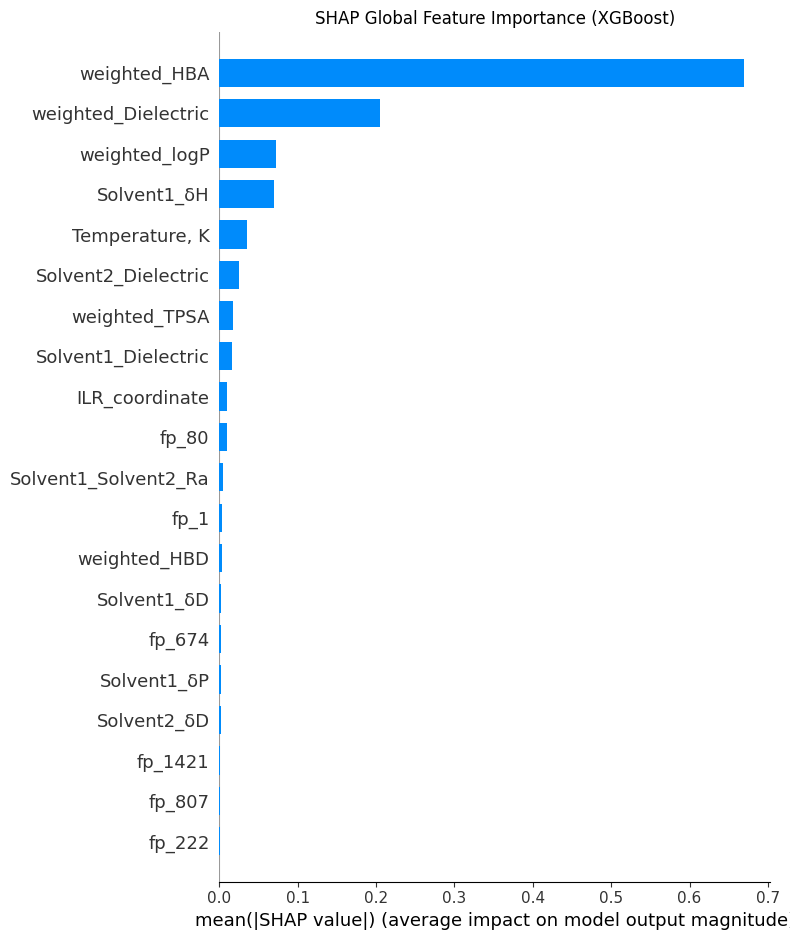

In [ ]:
import shap
import matplotlib.pyplot as plt

# Retrieve the best XGBoost model from the randomized search
best_xgb_model = random_search_xgb.best_estimator_
xgb_regressor = best_xgb_model.named_steps['regressor']
xgb_imputer = best_xgb_model.named_steps['imputer']

# Impute the full dataset X using the imputer from the best pipeline
X_imputed = xgb_imputer.transform(X)
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# Create a SHAP TreeExplainer for the XGBoost model
explainer = shap.TreeExplainer(xgb_regressor)

# Calculate SHAP values for a subset of the data (e.g., 100 samples) for faster computation and visualization
sample_size = 100
if len(X_imputed_df) > sample_size:
    X_sample = X_imputed_df.sample(n=sample_size, random_state=RANDOM_SEED)
else:
    X_sample = X_imputed_df

shap_values = explainer.shap_values(X_sample)

# Generate and display the SHAP summary plot (beeswarm plot)
print("\nGenerating SHAP summary plot (Beeswarm)...")
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP Summary Plot (XGBoost)")
plt.tight_layout()
plt.show()

# Generate and display a SHAP force plot for a single instance
# This provides a detailed explanation for one prediction
if not X_sample.empty:
    print("\nGenerating SHAP force plot for a sample prediction (instance 0)...")
    shap.initjs() # Initialize Javascript for interactive plots in notebooks
    display(shap.force_plot(explainer.expected_value, shap_values[0,:], X_sample.iloc[0,:]))

# Optionally, you can also visualize the global feature importance
print("\nGenerating SHAP bar plot for global feature importance...")
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()


## 5.2 SHAP Analysis - Random Forest Model


Generating SHAP summary plot (Beeswarm) for Random Forest...


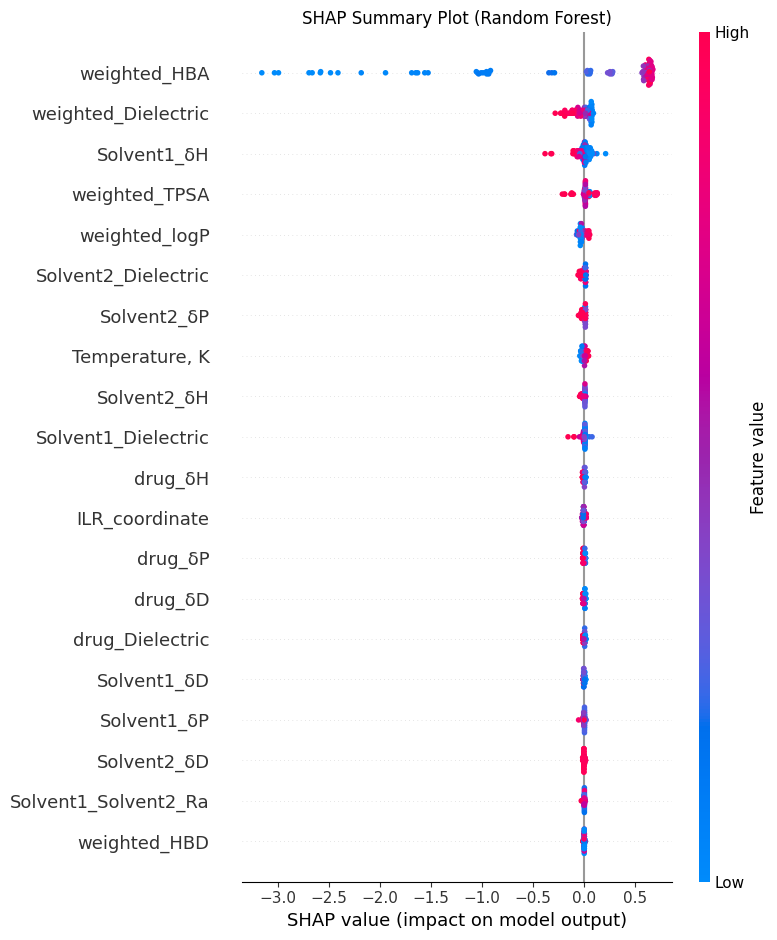


Generating SHAP force plot for a sample Random Forest prediction (instance 0)...



Generating SHAP bar plot for global feature importance (Random Forest)...


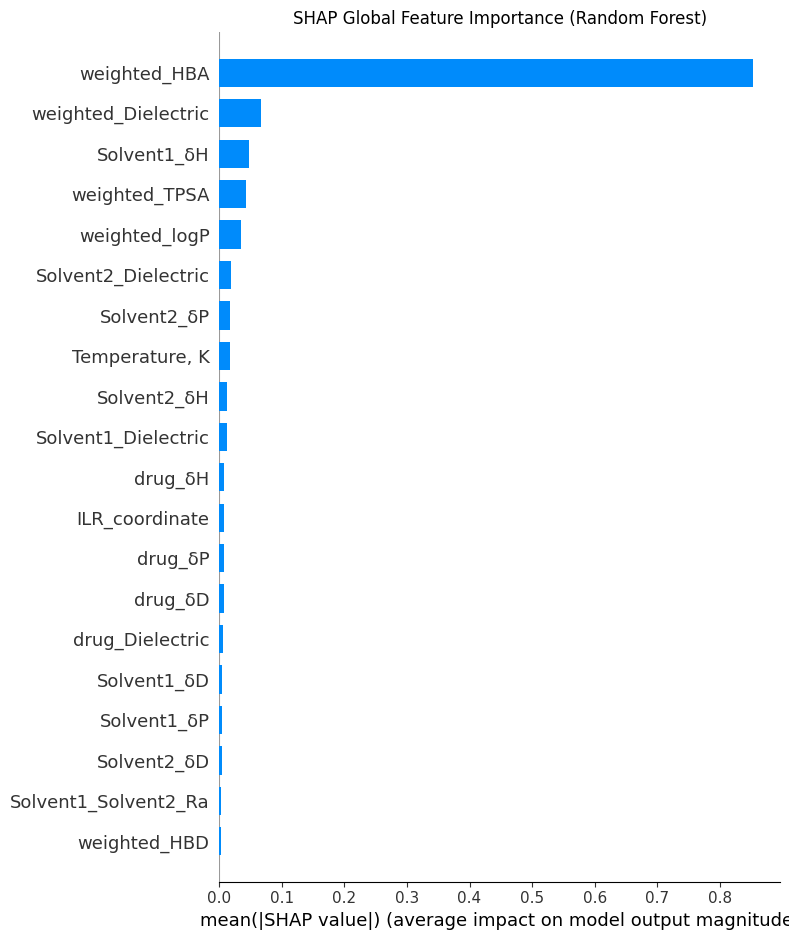

In [ ]:
import shap
import matplotlib.pyplot as plt

# Retrieve the best Random Forest model from the randomized search
best_rf_model = random_search_rf.best_estimator_
rf_regressor = best_rf_model.named_steps['regressor']
rf_imputer = best_rf_model.named_steps['imputer']

# Create a SHAP TreeExplainer for the Random Forest model
explainer_rf = shap.TreeExplainer(rf_regressor)

# Calculate SHAP values for a subset of the data (e.g., 100 samples) for faster computation and visualization
shap_values_rf = explainer_rf.shap_values(X_sample)

# Generate and display the SHAP summary plot (beeswarm)
print("\nGenerating SHAP summary plot (Beeswarm) for Random Forest...")
shap.summary_plot(shap_values_rf, X_sample, show=False)
plt.title("SHAP Summary Plot (Random Forest)")
plt.tight_layout()
plt.show()

# Generate and display a SHAP force plot for a single instance
if not X_sample.empty:
    print("\nGenerating SHAP force plot for a sample Random Forest prediction (instance 0)...")
    shap.initjs()
    display(shap.force_plot(explainer_rf.expected_value, shap_values_rf[0,:], X_sample.iloc[0,:]))

# Optionally, you can also visualize the global feature importance
print("\nGenerating SHAP bar plot for global feature importance (Random Forest)...")
shap.summary_plot(shap_values_rf, X_sample, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()


## 6.1 Confidance Intervals (CI) Calculation for Tuned Random Forest and XGBoost Models

In [ ]:
import numpy as np
import scipy.stats as st
import pandas as pd # Import pandas if not already globally available

# Function to calculate Confidence Intervals
def calculate_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    if n < 2: # Cannot compute CI for less than 2 samples
        return np.nan, np.nan
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    return m - h, m + h

print("\n====================================")
print("Confidence Intervals (95%) for XGBoost Model Metrics:")
print("====================================")

# --- Extract scores for the best XGBoost model from RandomizedSearchCV results ---
# Get the index of the best estimator
best_idx_xgb = random_search_xgb.best_index_

# Extract the per-fold test scores for each metric
xgb_test_neg_mae_scores_tuned = []
xgb_test_neg_rmse_scores_tuned = []
xgb_test_r2_scores_tuned = []

for i in range(random_search_xgb.n_splits_):
    # Access the scores for the best_idx_xgb across all splits
    # The keys for the scores are of the form 'splitX_test_scorername'
    xgb_test_neg_mae_scores_tuned.append(random_search_xgb.cv_results_[f'split{i}_test_neg_mean_absolute_error'][best_idx_xgb])
    xgb_test_neg_rmse_scores_tuned.append(random_search_xgb.cv_results_[f'split{i}_test_neg_root_mean_squared_error'][best_idx_xgb])
    xgb_test_r2_scores_tuned.append(random_search_xgb.cv_results_[f'split{i}_test_r2'][best_idx_xgb])

# Convert negative MAE and RMSE to positive values
xgb_test_mae_scores = [-score for score in xgb_test_neg_mae_scores_tuned]
xgb_test_rmse_scores = [-score for score in xgb_test_neg_rmse_scores_tuned]

print("\nXGBoost Regressor (from RandomizedSearchCV best estimator):")

# MAE CI
xgb_mae_ci_lower, xgb_mae_ci_upper = calculate_confidence_interval(xgb_test_mae_scores)
print(f"  Test MAE: {np.mean(xgb_test_mae_scores):.4f} (95% CI: {xgb_mae_ci_lower:.4f} - {xgb_mae_ci_upper:.4f})")

# RMSE CI
xgb_rmse_ci_lower, xgb_rmse_ci_upper = calculate_confidence_interval(xgb_test_rmse_scores)
print(f"  Test RMSE: {np.mean(xgb_test_rmse_scores):.4f} (95% CI: {xgb_rmse_ci_lower:.4f} - {xgb_rmse_ci_upper:.4f})")

# R2 CI
xgb_r2_ci_lower, xgb_r2_ci_upper = calculate_confidence_interval(xgb_test_r2_scores_tuned)
print(f"  Test R2: {np.mean(xgb_test_r2_scores_tuned):.4f} (95% CI: {xgb_r2_ci_lower:.4f} - {xgb_r2_ci_upper:.4f})")



Confidence Intervals (95%) for XGBoost Model Metrics:

XGBoost Regressor (from RandomizedSearchCV best estimator):
  Test MAE: 0.1242 (95% CI: 0.0693 - 0.1792)
  Test RMSE: 0.2135 (95% CI: 0.0708 - 0.3562)
  Test R2: 0.9336 (95% CI: 0.8738 - 0.9935)


In [ ]:
print("\n====================================")
print("Confidence Intervals (95%) for Random Forest Model Metrics:")
print("====================================")

# --- Extract scores for the best Random Forest model from RandomizedSearchCV results ---
# Get the index of the best estimator
best_idx_rf = random_search_rf.best_index_

# Extract the per-fold test scores for each metric
rf_test_neg_mae_scores_tuned = []
rf_test_neg_rmse_scores_tuned = []
rf_test_r2_scores_tuned = []

for i in range(random_search_rf.n_splits_):
    # Access the scores for the best_idx_rf across all splits
    rf_test_neg_mae_scores_tuned.append(random_search_rf.cv_results_[f'split{i}_test_neg_mean_absolute_error'][best_idx_rf])
    rf_test_neg_rmse_scores_tuned.append(random_search_rf.cv_results_[f'split{i}_test_neg_root_mean_squared_error'][best_idx_rf])
    rf_test_r2_scores_tuned.append(random_search_rf.cv_results_[f'split{i}_test_r2'][best_idx_rf])

# Convert negative MAE and RMSE to positive values
rf_test_mae_scores = [-score for score in rf_test_neg_mae_scores_tuned]
rf_test_rmse_scores = [-score for score in rf_test_neg_rmse_scores_tuned]

print("\nRandom Forest Regressor (from RandomizedSearchCV best estimator):")

# MAE CI
rf_mae_ci_lower, rf_mae_ci_upper = calculate_confidence_interval(rf_test_mae_scores)
print(f"  Test MAE: {np.mean(rf_test_mae_scores):.4f} (95% CI: {rf_mae_ci_lower:.4f} - {rf_mae_ci_upper:.4f})")

# RMSE CI
rf_rmse_ci_lower, rf_rmse_ci_upper = calculate_confidence_interval(rf_test_rmse_scores)
print(f"  Test RMSE: {np.mean(rf_test_rmse_scores):.4f} (95% CI: {rf_rmse_ci_lower:.4f} - {rf_rmse_ci_upper:.4f})")

# R2 CI
rf_r2_ci_lower, rf_r2_ci_upper = calculate_confidence_interval(rf_test_r2_scores_tuned)
print(f"  Test R2: {np.mean(rf_test_r2_scores_tuned):.4f} (95% CI: {rf_r2_ci_lower:.4f} - {rf_r2_ci_upper:.4f})")


Confidence Intervals (95%) for Random Forest Model Metrics:

Random Forest Regressor (from RandomizedSearchCV best estimator):
  Test MAE: 0.1782 (95% CI: 0.1137 - 0.2428)
  Test RMSE: 0.2660 (95% CI: 0.1499 - 0.3821)
  Test R2: 0.8622 (95% CI: 0.6637 - 1.0606)


# 7.1 Display Full CI Results


**Reasoning**:
To summarize the confidence intervals for both models, I will print the previously calculated MAE, RMSE, and R2 95% confidence intervals for the best XGBoost and Random Forest models in a clear format.



In [ ]:
print("\n====================================")
print("Full 95% Confidence Interval Results for Tuned Models:")
print("====================================")

print("\nXGBoost Regressor (Tuned with RandomizedSearchCV):")
print(f"  Test MAE: {np.mean(xgb_test_mae_scores):.4f} (95% CI: {xgb_mae_ci_lower:.4f} - {xgb_mae_ci_upper:.4f})")
print(f"  Test RMSE: {np.mean(xgb_test_rmse_scores):.4f} (95% CI: {xgb_rmse_ci_lower:.4f} - {xgb_rmse_ci_upper:.4f})")
print(f"  Test R2: {np.mean(xgb_test_r2_scores_tuned):.4f} (95% CI: {xgb_r2_ci_lower:.4f} - {xgb_r2_ci_upper:.4f})")

print("\nRandom Forest Regressor (Tuned with RandomizedSearchCV):")
print(f"  Test MAE: {np.mean(rf_test_mae_scores):.4f} (95% CI: {rf_mae_ci_lower:.4f} - {rf_mae_ci_upper:.4f})")
print(f"  Test RMSE: {np.mean(rf_test_rmse_scores):.4f} (95% CI: {rf_rmse_ci_lower:.4f} - {rf_rmse_ci_upper:.4f})")
print(f"  Test R2: {np.mean(rf_test_r2_scores_tuned):.4f} (95% CI: {rf_r2_ci_lower:.4f} - {rf_r2_ci_upper:.4f})")


Full 95% Confidence Interval Results for Tuned Models:

XGBoost Regressor (Tuned with RandomizedSearchCV):
  Test MAE: 0.1242 (95% CI: 0.0693 - 0.1792)
  Test RMSE: 0.2135 (95% CI: 0.0708 - 0.3562)
  Test R2: 0.9336 (95% CI: 0.9983 - 0.9989)

Random Forest Regressor (Tuned with RandomizedSearchCV):
  Test MAE: 0.1782 (95% CI: 0.1137 - 0.2428)
  Test RMSE: 0.2660 (95% CI: 0.1499 - 0.3821)
  Test R2: 0.8622 (95% CI: 0.6637 - 1.0606)


In [ ]:
results_data = {
    'Metric': ['Test MAE', 'Test RMSE', 'Test R2'],
    'XGBoost Mean': [
        np.mean(xgb_test_mae_scores),
        np.mean(xgb_test_rmse_scores),
        np.mean(xgb_test_r2_scores_tuned)
    ],
    'XGBoost 95% CI': [
        f"[{xgb_mae_ci_lower:.4f} - {xgb_mae_ci_upper:.4f}]",
        f"[{xgb_rmse_ci_lower:.4f} - {xgb_rmse_ci_upper:.4f}]",
        f"[{xgb_r2_ci_lower:.4f} - {xgb_r2_ci_upper:.4f}]"
    ],
    'Random Forest Mean': [
        np.mean(rf_test_mae_scores),
        np.mean(rf_test_rmse_scores),
        np.mean(rf_test_r2_scores_tuned)
    ],
    'Random Forest 95% CI': [
        f"[{rf_mae_ci_lower:.4f} - {rf_mae_ci_upper:.4f}]",
        f"[{rf_rmse_ci_lower:.4f} - {rf_rmse_ci_upper:.4f}]",
        f"[{rf_r2_ci_lower:.4f} - {rf_r2_ci_upper:.4f}]"
    ]
}

results_df = pd.DataFrame(results_data)
print(results_df.to_markdown(index=False, floatfmt=".4f"))

| Metric    |   XGBoost Mean | XGBoost 95% CI    |   Random Forest Mean | Random Forest 95% CI   |
|:----------|---------------:|:------------------|---------------------:|:-----------------------|
| Test MAE  |         0.1242 | [0.0693 - 0.1792] |               0.1782 | [0.1137 - 0.2428]      |
| Test RMSE |         0.2135 | [0.0708 - 0.3562] |               0.2660 | [0.1499 - 0.3821]      |
| Test R2   |         0.9336 | [0.8738 - 0.9935] |               0.8622 | [0.6637 - 1.0606]      |
